The code requires the modeling results file. It should be downloaded from https://github.com/icredd-cheminfo/Photoswitches repository.

## Initial imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import glob, os, pickle
from sklearn.datasets import load_svmlight_file, dump_svmlight_file
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from doptools.chem.chem_features import ChythonCircus, Fingerprinter, ComplexFragmentor, ChythonLinear
from doptools.chem.solvents import SolventVectorizer
from chython import smiles

def r2(a, b):
    return 1. - np.sum((a-b)**2)/np.sum((a-np.mean(a))**2)

def rmse(a, b):
    return np.sqrt(np.sum((a-b)**2)/len(a))

from sklearn.metrics import mean_absolute_error as mae

colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00']

In [2]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
#rc('font',**{'family':'serif','serif':['Times']})

In [3]:
%config IPCompleter.use_jedi = False

# Reading data

In [4]:
fdata = pd.read_excel('Photoswitch data.xls', sheet_name='Full set')
fdata['mol'] = [smiles(c) for c in fdata['SMILES']]
[c.canonicalize() for c in fdata.mol]
[c.clean2d() for c in fdata.mol]
print()

# Dataset preparation

The code here separate the training and test sets for both absorption maximum and half-life. The separated sets can also be found in the initial Excel file on the separate sheets. The code is reproducible as it uses specific random seeds.

120 14


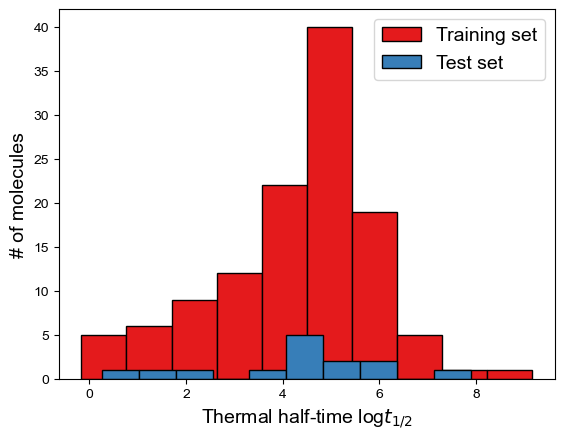

In [5]:
from numpy import histogram
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split

fdata_log = fdata[pd.notnull(fdata["logt12"])]

kbd_logt12 = KBinsDiscretizer(n_bins=10, encode="ordinal")
a = kbd_logt12.fit_transform(fdata_log[["logt12"]])

logt12_labels = np.ravel(a)

train_logt12, test_logt12 = train_test_split(fdata_log.index, test_size=0.1, stratify=logt12_labels, random_state=10)

plt.hist(fdata_log["logt12"].loc[train_logt12], color=colors[0], edgecolor='k', label="Training set")
plt.hist(fdata_log["logt12"].loc[test_logt12], color=colors[1], edgecolor='k', label="Test set")
plt.ylabel("# of molecules", fontsize=14)
plt.xlabel(r"Thermal half-time log$t_{1/2}$", fontsize=14)
plt.legend(fontsize=14)
print(len(train_logt12), len(test_logt12))

fdata_log.loc[train_logt12].to_excel("fulldata.logt12_train.xlsx")
fdata_log.loc[test_logt12].to_excel("fulldata.logt12_test.xlsx")
#plt.savefig("Histogram logt12.png")

718 80


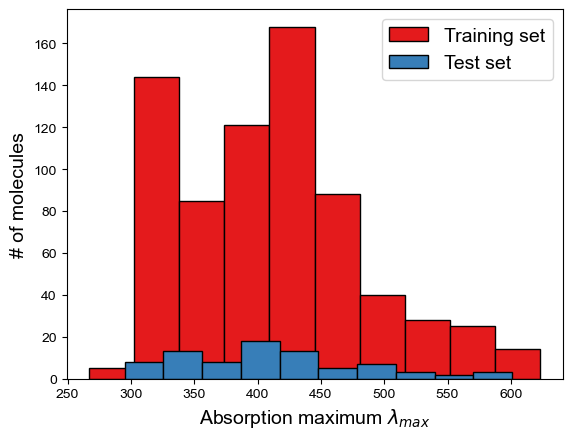

In [6]:
fdata_lambda = fdata[pd.notnull(fdata["lambda"])]

kbd_lambda = KBinsDiscretizer(n_bins=10, encode="ordinal")
a = kbd_lambda.fit_transform(fdata_lambda[["lambda"]])

lambda_labels = np.ravel(a)

train_lambda, test_lambda = train_test_split(fdata_lambda.index, test_size=0.1, stratify=lambda_labels, random_state=42)

plt.hist(fdata_lambda["lambda"].loc[train_lambda], color=colors[0], edgecolor='k', label="Training set")
plt.hist(fdata_lambda["lambda"].loc[test_lambda], color=colors[1], edgecolor='k', label="Test set")
plt.ylabel("# of molecules", fontsize=14)
plt.xlabel(r"Absorption maximum $\lambda_{max}$", fontsize=14)
plt.legend(fontsize=14)
print(len(train_lambda), len(test_lambda))

fdata_lambda.loc[train_lambda].to_excel("fulldata.lambda_train.xlsx")
fdata_lambda.loc[test_lambda].to_excel("fulldata.lambda_test.xlsx")
#plt.savefig("Histogram lambda.png")

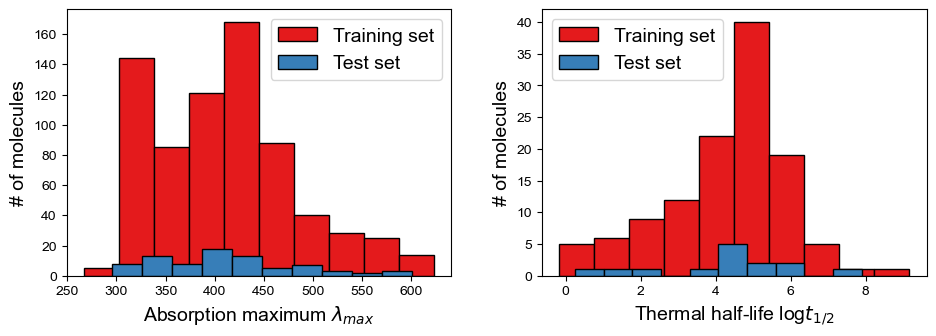

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), facecolor="w")

ax[0].hist(fdata_lambda["lambda"].loc[train_lambda], color=colors[0], edgecolor='k', label="Training set")
ax[0].hist(fdata_lambda["lambda"].loc[test_lambda], color=colors[1], edgecolor='k', label="Test set")
ax[0].set_ylabel("# of molecules", fontsize=14)
ax[0].set_xlabel(r"Absorption maximum $\lambda_{max}$", fontsize=14)
ax[0].legend(fontsize=14)

ax[1].hist(fdata_log["logt12"].loc[train_logt12], color=colors[0], edgecolor='k', label="Training set")
ax[1].hist(fdata_log["logt12"].loc[test_logt12], color=colors[1], edgecolor='k', label="Test set")
ax[1].set_ylabel("# of molecules", fontsize=14)
ax[1].set_xlabel(r"Thermal half-life log$t_{1/2}$", fontsize=14)
ax[1].legend(fontsize=14)
plt.tight_layout(pad=3)
#plt.savefig("Histogram lambda+logt12.png", dpi=300)

### Alternative test set

In [35]:
cl26 = ChythonLinear(2, 6)
cl26_descs = cl26.fit_transform(fdata_log["mol"])

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15)
kmeans.fit(cl26_descs)
distances = kmeans.transform(cl26_descs)
test_logt12_clustering = fdata_log.iloc[np.argmin(distances, axis=0)]
train_logt12_clustering = fdata_log.drop(index=fdata_log.index[np.argmin(distances, axis=0)])
test_logt12_clustering.shape, train_logt12_clustering.shape

((15, 7), (119, 7))

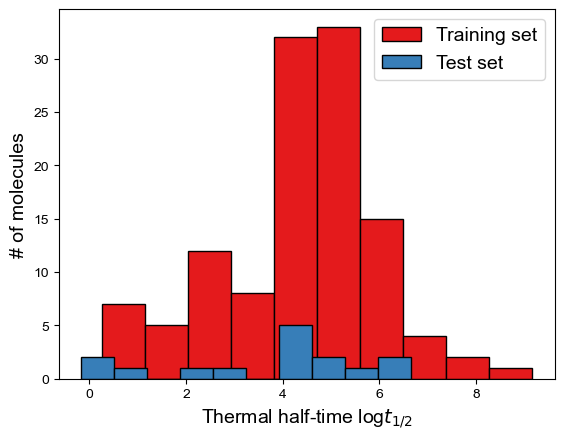

In [140]:
plt.hist(train_logt12_clustering["logt12"], color=colors[0], edgecolor='k', label="Training set")
plt.hist(test_logt12_clustering["logt12"], color=colors[1], edgecolor='k', label="Test set")
plt.ylabel("# of molecules", fontsize=14)
plt.xlabel(r"Thermal half-time log$t_{1/2}$", fontsize=14)
plt.legend(fontsize=14)
plt.savefig("clustering distribution.png")

In [45]:
train_logt12_clustering.to_excel("fulldata.logt12_train_clustering.xlsx")
test_logt12_clustering.to_excel("fulldata.logt12_test_clustering.xlsx")

# Best models for prediction of $\lambda_{max}$

The code here reads the benchmark results for models predictiong absorption maximum and reconstructs the plots. The example code is given for reconstructing the plots for SVM models, however, Random forest or XGBoost models can also be recreated by changing the folder names (adding RFR or XG in the end for all of them emtries in the 'names' variable).

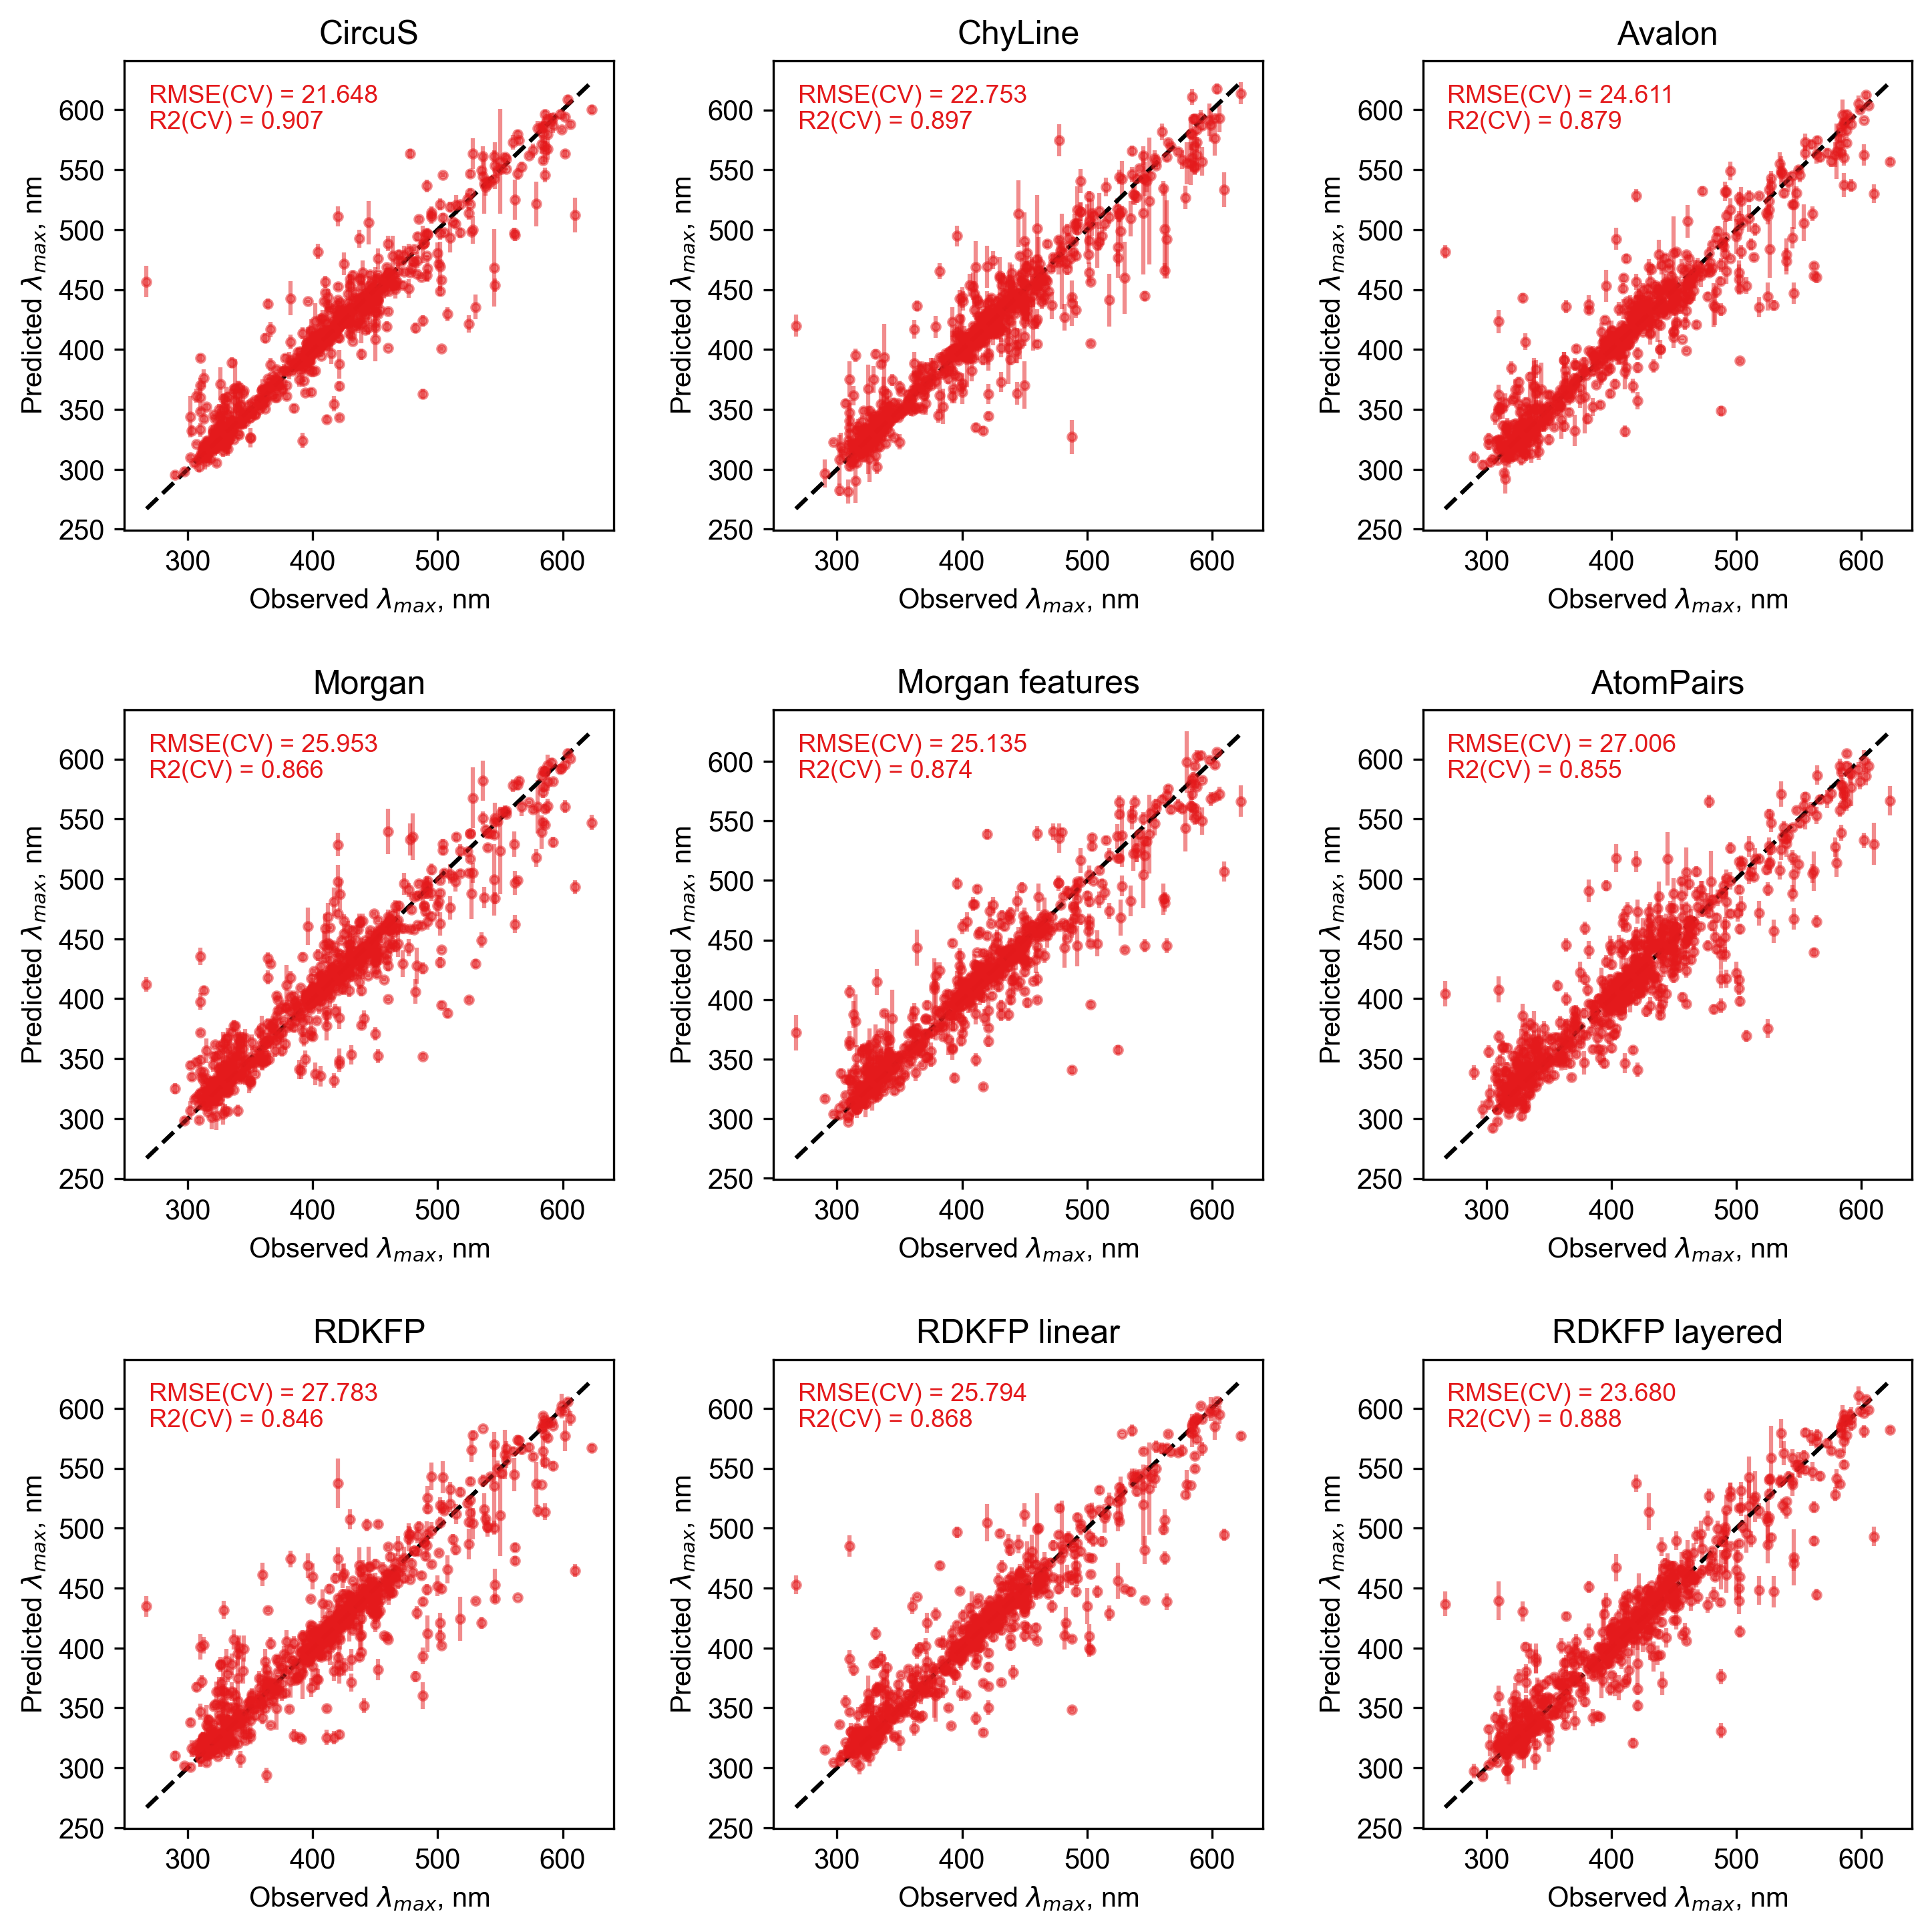

In [28]:
names = {'RDKFP':'models/lambda models/Model_lambda_rdkfp',
         'RDKFP layered':'models/lambda models/Model_lambda_layered',
         'ChyLine':'models/lambda models/Model_lambda_chyline',
         'Morgan':'models/lambda models/Model_lambda_morgan',
         'CircuS':'models/lambda models/Model_lambda_circus',
         'RDKFP linear':'models/lambda models/Model_lambda_rdkfplinear',
         'AtomPairs':'models/lambda models/Model_lambda_atompairs',
         'Morgan features':'models/lambda models/Model_lambda_morganfeatures',
         'Avalon':'models/lambda models/Model_lambda_avalon'}

fig, ax = plt.subplots(3, 3, figsize=(10,10), dpi=300, facecolor="white")

for i, dtype in enumerate(["CircuS", "ChyLine", "Avalon", "Morgan", 'Morgan features', 'AtomPairs', 
                           "RDKFP", "RDKFP linear", 'RDKFP layered']):
    d = dtype.lower()

    best = pd.read_table(names[dtype]+'/trials.best', sep=' ').iloc[0].trial
    cv_res = pd.read_table(names[dtype]+"/trial."+str(best)+"/predictions", sep=' ')
    a = cv_res["lambdaa.observed"]
    b = cv_res[['lambdaa.predicted.repeat'+str(i) for i in range(1,11)]]
    
    ax[i//3, i%3].errorbar(a,b.mean(axis=1),
                           b.std(axis=1), fmt=".", color=colors[0], alpha=0.5)
    
    ax[i//3, i%3].plot([a.min(), a.max()], [a.min(), a.max()], "k--")
    ax[i//3, i%3].set_xlabel(r"Observed $\lambda_{max}$, nm")
    ax[i//3, i%3].set_ylabel(r"Predicted $\lambda_{max}$, nm")
    ax[i//3, i%3].set_title(dtype)
    textstr = "\n".join([
        "RMSE(CV) = %.3f"  % (rmse(a,b.mean(axis=1)), ),
        "R2(CV) = %.3f"  % (r2(a,b.mean(axis=1)), )
            ])
    ax[i//3, i%3].text(0.05, 0.95, textstr, transform=ax[i//3, i%3].transAxes,
                       fontsize=9, color=colors[0],
                       verticalalignment="top", horizontalalignment="left",
                       bbox={"boxstyle":"round", "facecolor":"white", "alpha":0})
    

plt.tight_layout(pad=2)
#plt.savefig('SI - all Lambda models.png')

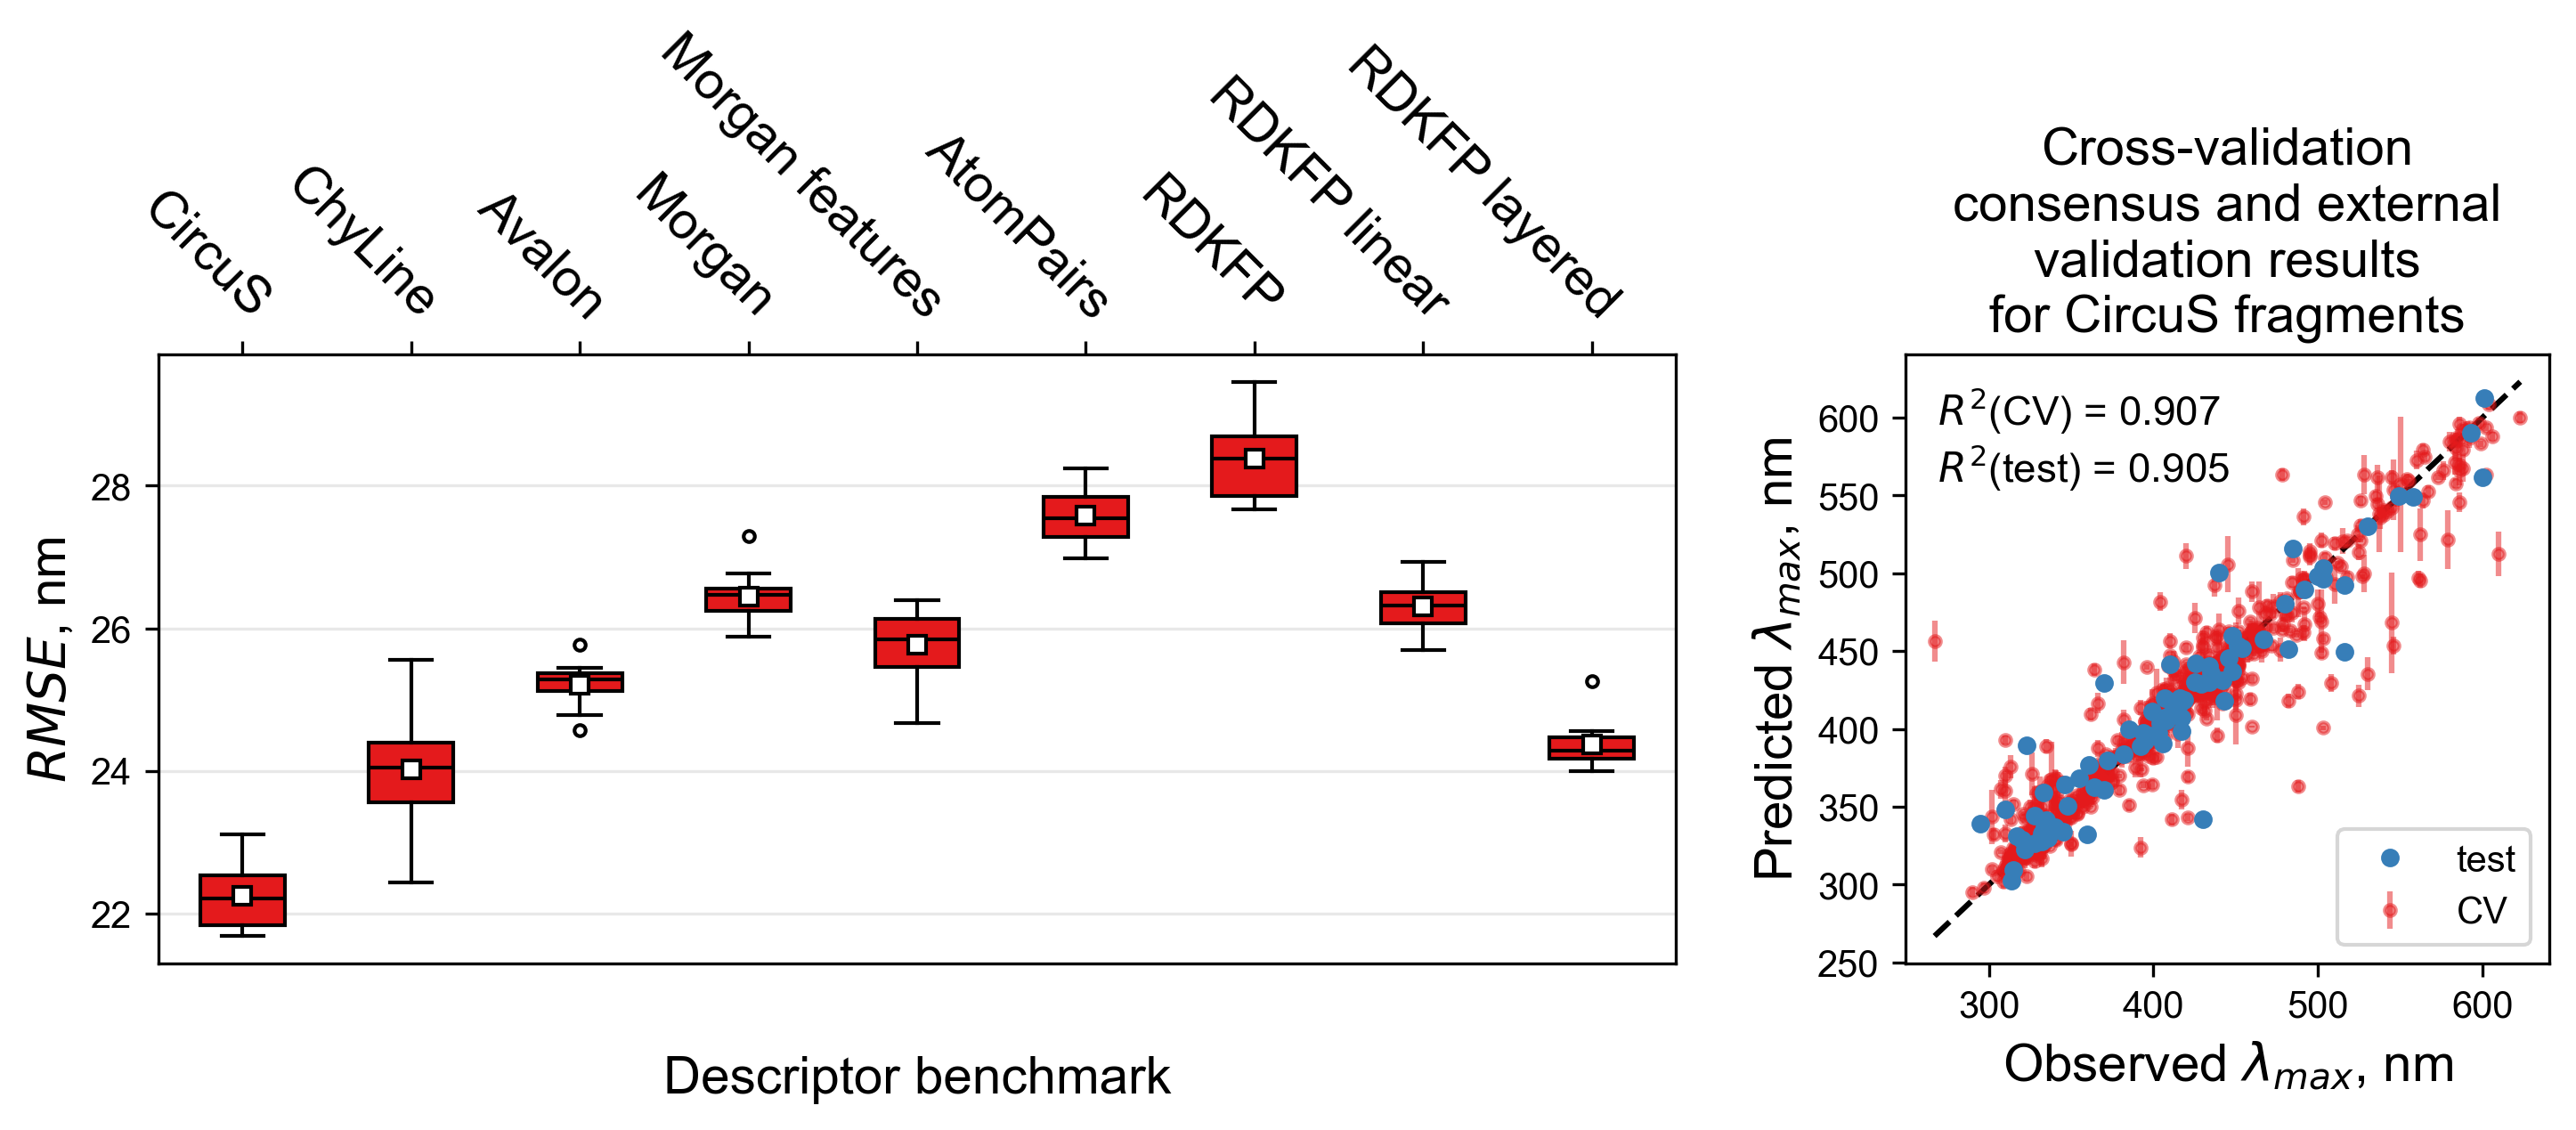

In [29]:
names = {'RDKFP':'models/lambda models/Model_lambda_rdkfp',
         'RDKFP layered':'models/lambda models/Model_lambda_layered',
         'ChyLine':'models/lambda models/Model_lambda_chyline',
         'Morgan':'models/lambda models/Model_lambda_morgan',
         'CircuS':'models/lambda models/Model_lambda_circus',
         'RDKFP linear':'models/lambda models/Model_lambda_rdkfplinear',
         'AtomPairs':'models/lambda models/Model_lambda_atompairs',
         'Morgan features':'models/lambda models/Model_lambda_morganfeatures',
         'Avalon':'models/lambda models/Model_lambda_avalon'}

fig = plt.figure(figsize = (10,4.8), dpi=300, facecolor="w")

ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 3), (0, 2))

cv_r2_results = []
for i, dtype in enumerate(["CircuS", "ChyLine", "Avalon", "Morgan", 'Morgan features', 'AtomPairs', 
                           "RDKFP", "RDKFP linear", 'RDKFP layered']):
    d = dtype.lower()
    cv_r2_results.append([])

    best = pd.read_table(names[dtype]+'/trials.best', sep=' ').iloc[0].trial
    cv_res = pd.read_table(names[dtype]+"/trial."+str(best)+"/predictions", sep=' ')
    a = cv_res["lambdaa.observed"]
    for i in range(1,11):
        b = cv_res['lambdaa.predicted.repeat'+str(i)]
        cv_r2_results[-1].append(rmse(a,b))

bp1 = ax1.boxplot(cv_r2_results, positions=[0,1,2,3,4,5,6,7,8],
                  patch_artist=True, showmeans=True)
for median in bp1['medians']:
    median.set(color='k', linewidth=1)
for mean in bp1['means']:
    mean.set(marker='s', markerfacecolor='w', markeredgecolor='k', markersize=5)
for item in ['boxes', 'whiskers', 'fliers', 'caps']:
        plt.setp(bp1[item], color='k')
plt.setp(bp1["boxes"], facecolor=colors[0], edgecolor='k')
plt.setp(bp1["fliers"], markeredgecolor='k', markersize=3)

ax1.set_xticks([0,1,2,3,4,5,6,7,8])
ax1.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
ax1.set_xticklabels(["CircuS", "ChyLine", "Avalon", "Morgan", 'Morgan features', 'AtomPairs', 
                           "RDKFP", "RDKFP linear", 'RDKFP layered'], 
                    rotation=-45, fontsize=14,
                    ha="right",rotation_mode="anchor")
ax1.set_ylabel(r"$RMSE$, nm", fontsize=14)#, rotation=0, labelpad=-15, loc="top")
#ax.set_ylim([0.75, 0.95])
ax1.grid(color="lightgrey", axis="y", alpha=.5)
ax1.text(0.5, -0.15, 'Descriptor benchmark', transform=ax1.transAxes,
                       fontsize=14, color='k',
                       verticalalignment="top", horizontalalignment="center")

best = pd.read_table(names['CircuS']+'/trials.best', sep=' ').iloc[0].trial
cv_res = pd.read_table(names['CircuS']+"/trial."+str(best)+"/predictions", sep=' ')
a = cv_res["lambdaa.observed"]
b = cv_res[['lambdaa.predicted.repeat'+str(i) for i in range(1,11)]]
    
ax2.errorbar(a,b.mean(axis=1), b.std(axis=1), fmt=".", color=colors[0], alpha=0.5, label="CV")
    
ax2.plot([a.min(), a.max()], [a.min(), a.max()], "k--")

ext_preds = pd.read_table("Model files/SVR_lambda/predictions_lambda_bydesc.csv", sep=",")

ax2.plot(ext_preds["observed"], ext_preds["predicted_circus"], 'o', color=colors[1], markersize=4,  zorder=10, label="test")
ax2.set_xlabel(r"Observed $\lambda_{max}$, nm", fontsize=14)
ax2.set_ylabel(r"Predicted $\lambda_{max}$, nm", fontsize=14)
ax2.set_title('Cross-validation\nconsensus and external\nvalidation results\nfor CircuS fragments', fontsize=14)
#textstr = r"$RMSE$(CV) = " + str(round(rmse(a,b.mean(axis=1)),2)) + '\n' + 
textstr = r"$R^2$(CV) = " + str(round(r2(a,b.mean(axis=1)), 3))
textstr += '\n' + r"$R^2$(test) = " + str(round(r2(ext_preds["observed"], ext_preds["predicted_circus"]), 3))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes,
                       fontsize=11, color='k',
                       verticalalignment="top", horizontalalignment="left",
                       bbox={"boxstyle":"round", "facecolor":"white", "alpha":0})

ax2.legend(loc=4)
plt.tight_layout(pad=2)
#plt.savefig('SI - Benchmark and best model for lambda.png', dpi=300)

# Best models for predictions of log$t_{1/2}$

Similar to previous, the code here reads the benchmark results for models predictiong half-life and reconstructs the plots. Random forest or XGBoost models can also be recreated by changing the folder names (adding RFR or XG in the end for all of them emtries in the 'names' variable).

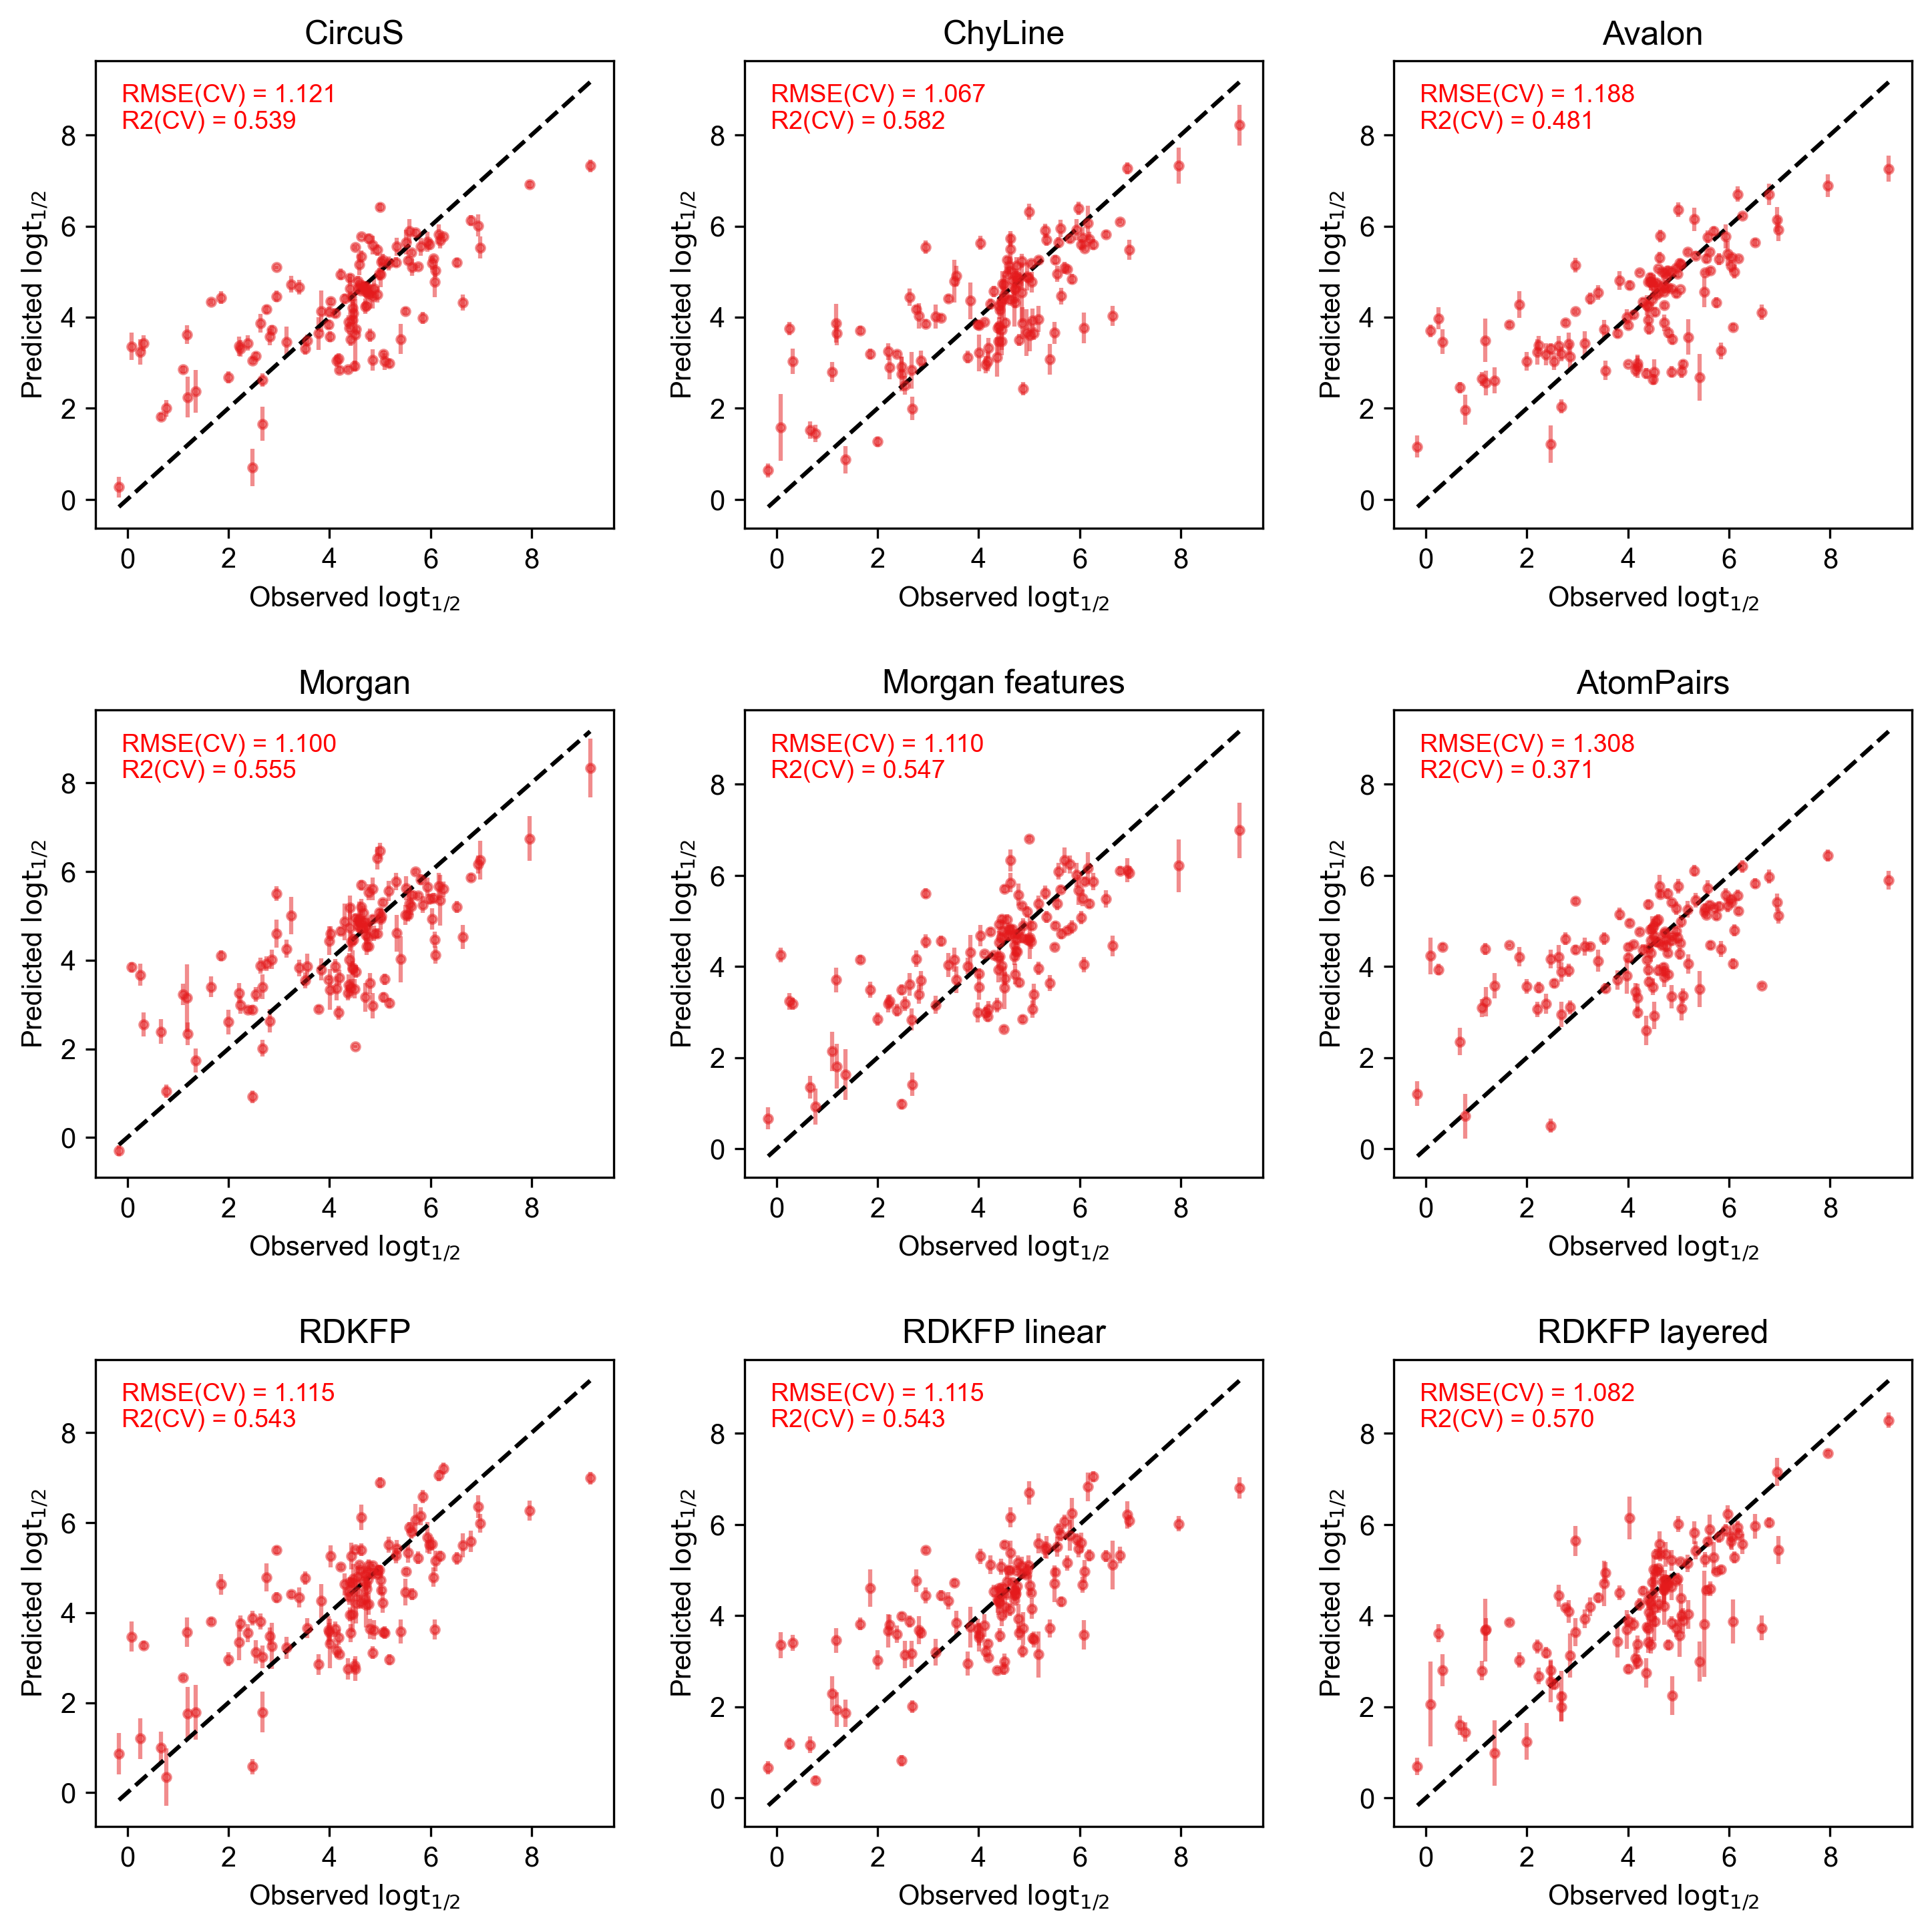

In [12]:
names = {'RDKFP':'models/logt12 models/Model_logt12_rdkfp',
         'RDKFP layered':'models/logt12 models/Model_logt12_layered',
         'ChyLine':'models/logt12 models/Model_logt12_chyline',
         'Morgan':'models/logt12 models/Model_logt12_morgan',
         'CircuS':'models/logt12 models/Model_logt12_circus',
         'RDKFP linear':'models/logt12 models/Model_logt12_rdkfplinear',
         'AtomPairs':'models/logt12 models/Model_logt12_atompairs',
         'Morgan features':'models/logt12 models/Model_logt12_morganfeatures',
         'Avalon':'models/logt12 models/Model_logt12_avalon'}

fig, ax = plt.subplots(3, 3, figsize=(10,10), dpi=300, facecolor="white")

for i, dtype in enumerate(["CircuS", "ChyLine", "Avalon", "Morgan", 'Morgan features', 'AtomPairs', 
                           "RDKFP", "RDKFP linear", 'RDKFP layered']):
    d = dtype.lower()

    best = pd.read_table(names[dtype]+'/trials.best', sep=' ').iloc[0].trial
    cv_res = pd.read_table(names[dtype]+"/trial."+str(best)+"/predictions", sep=' ')
    a = cv_res["Htime.observed"]
    b = cv_res[['Htime.predicted.repeat'+str(i) for i in range(1,11)]]

    fdata_logt12 = fdata[pd.notnull(fdata.logt12)]
    fdata_logt12 = fdata_logt12.reset_index()
    ind_switches = fdata_logt12[fdata_logt12.subset == 'switches'].index
    ind_double = fdata_logt12[fdata_logt12.subset == 'double_prop'].index

    ax[i//3, i%3].errorbar(a,b.mean(axis=1),
                           b.std(axis=1), fmt=".", color=colors[0], alpha=0.5)
    
    ax[i//3, i%3].plot([a.min(), a.max()], [a.min(), a.max()], "k--")
    ax[i//3, i%3].set_xlabel(r"Observed $\rm{log} t_{1/2}$")
    ax[i//3, i%3].set_ylabel(r"Predicted $\rm{log} t_{1/2}$")
    ax[i//3, i%3].set_title(dtype)

    textstr = "\n".join([
        "RMSE(CV) = %.3f"  % (rmse(a,b.mean(axis=1)), ),
        "R2(CV) = %.3f"  % (r2(a,b.mean(axis=1)), )
            ])
    ax[i//3, i%3].text(0.05, 0.95, textstr, transform=ax[i//3, i%3].transAxes,
                       fontsize=9, color='red',
                       verticalalignment="top", horizontalalignment="left",
                       bbox={"boxstyle":"round", "facecolor":"white", "alpha":0})
    
plt.tight_layout(pad=2)
#plt.savefig('SI - logt12 models.png')

In [14]:
pd.read_table('models/logt12 models/Model_logt12_chyline/trials.best', sep=' ').iloc[0]

trial              403
score         0.581698
desc       chyline_2_6
scaling       original
method             SVR
C            34.929173
kernel             rbf
coef0        -3.067975
Name: 0, dtype: object

# Summary plot for models predicting log$t_{1/2}$

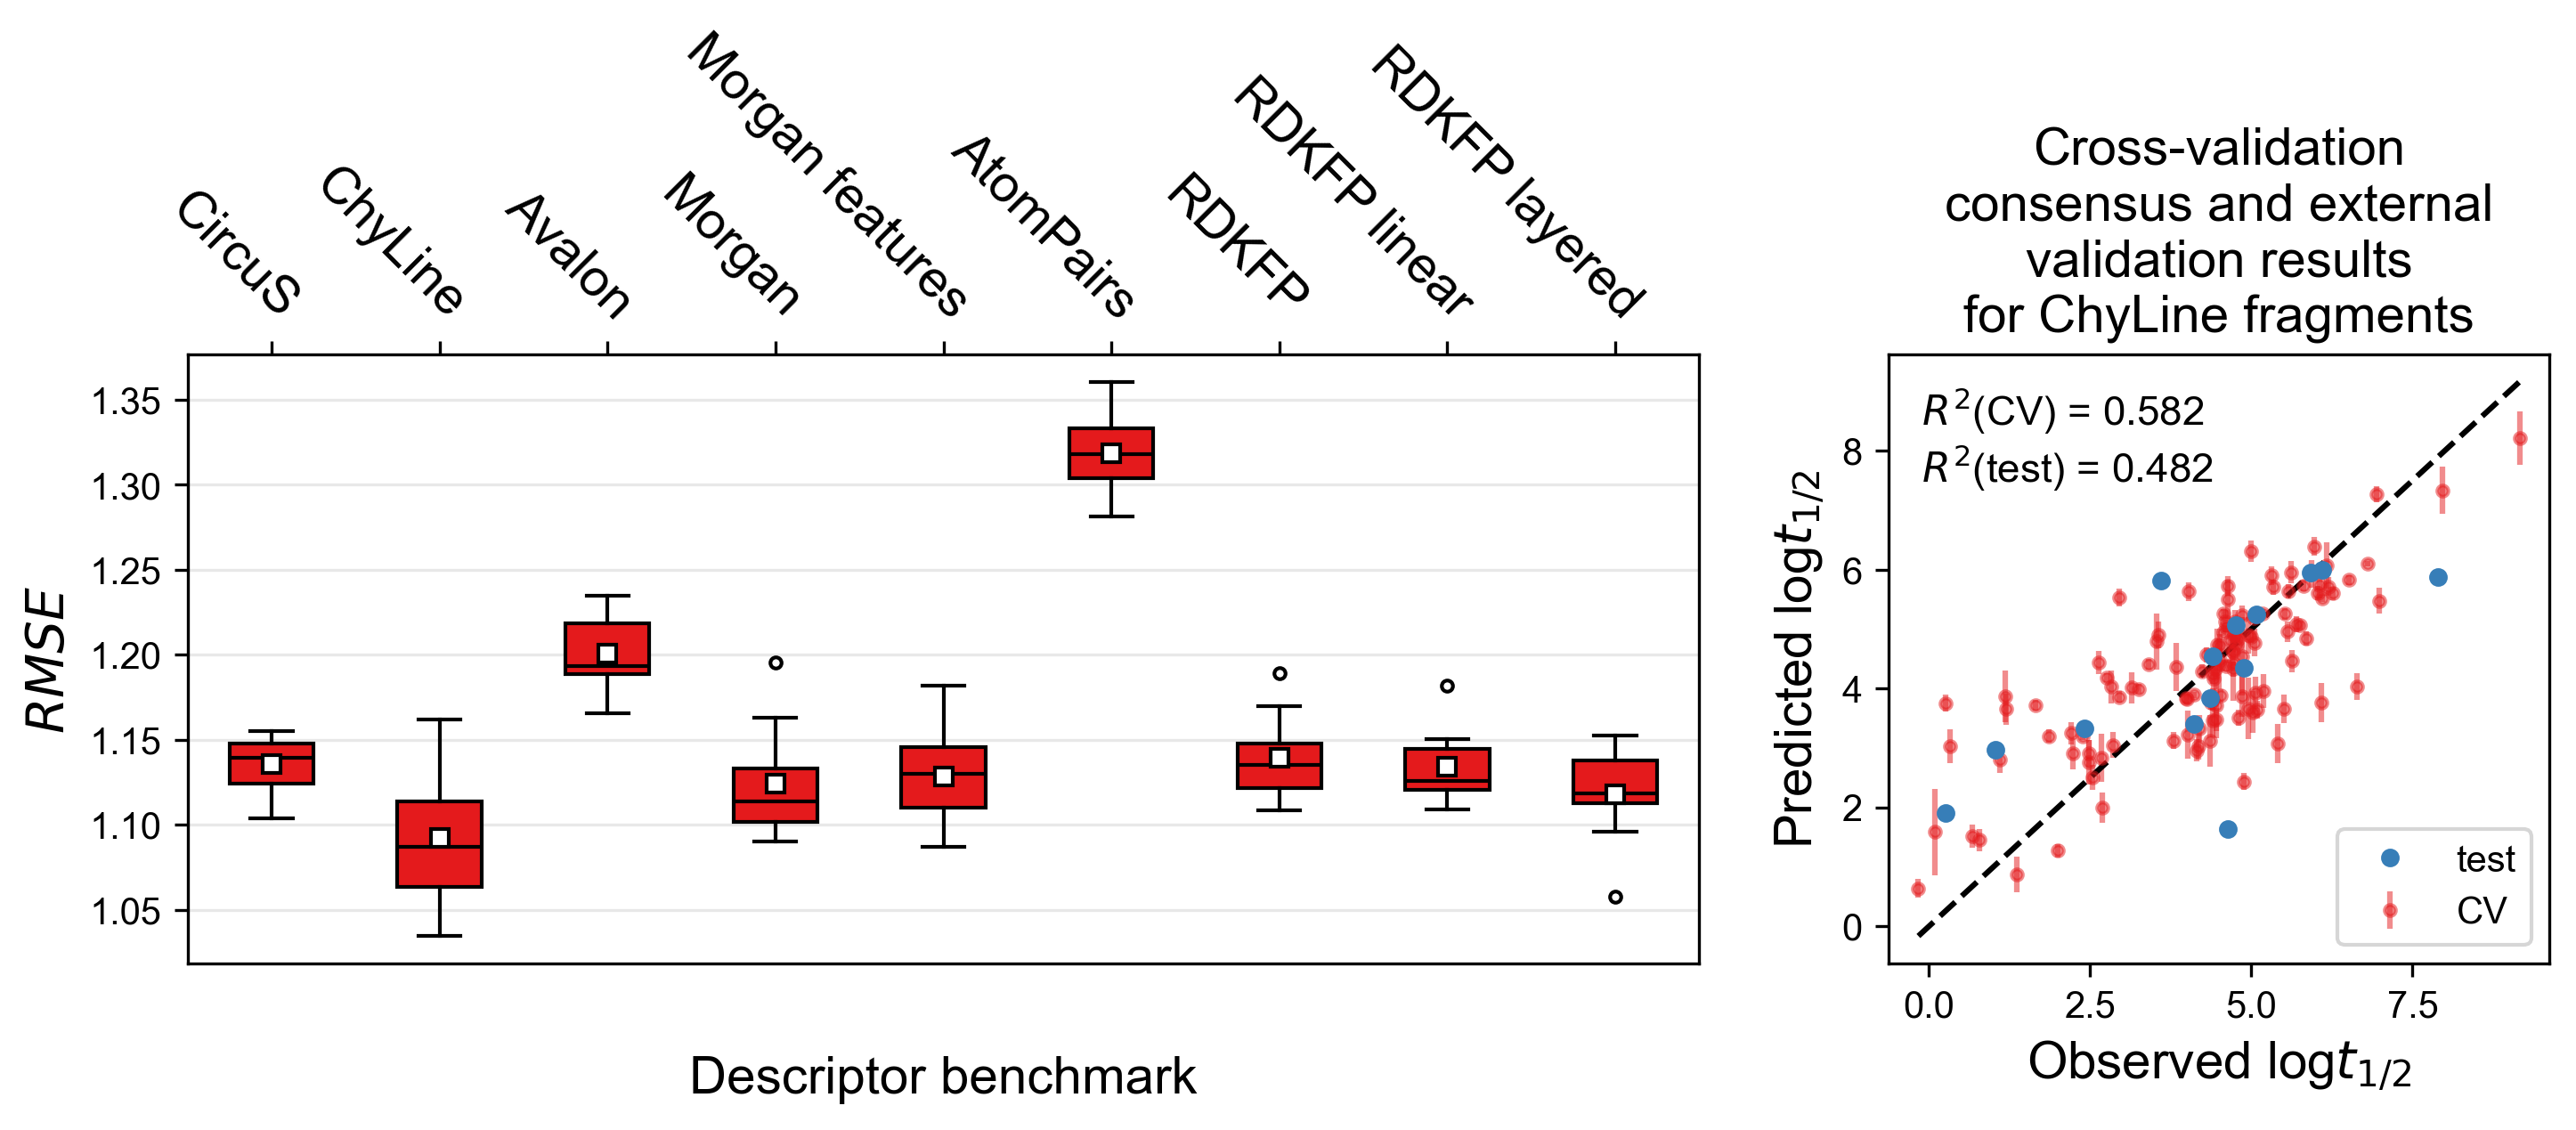

In [11]:
names = {'RDKFP':'models/logt12 models/Model_logt12_rdkfp',
         'RDKFP layered':'models/logt12 models/Model_logt12_layered',
         'ChyLine':'models/logt12 models/Model_logt12_chyline',
         'Morgan':'models/logt12 models/Model_logt12_morgan',
         'CircuS':'models/logt12 models/Model_logt12_circus',
         'RDKFP linear':'models/logt12 models/Model_logt12_rdkfplinear',
         'AtomPairs':'models/logt12 models/Model_logt12_atompairs',
         'Morgan features':'models/logt12 models/Model_logt12_morganfeatures',
         'Avalon':'models/logt12 models/Model_logt12_avalon'}

fig = plt.figure(figsize = (10,4.8), dpi=300, facecolor="w")

ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 3), (0, 2))

#fig, ax = plt.subplots(1,3, figsize = (13.4,4.5), dpi=300, facecolor="w")

cv_r2_results = []
for i, dtype in enumerate(["CircuS", "ChyLine", "Avalon", "Morgan", 'Morgan features', 'AtomPairs', 
                           "RDKFP", "RDKFP linear", 'RDKFP layered']):
    d = dtype.lower()
    cv_r2_results.append([])

    best = pd.read_table(names[dtype]+'/trials.best', sep=' ').iloc[0].trial
    cv_res = pd.read_table(names[dtype]+"/trial."+str(best)+"/predictions", sep=' ')
    a = cv_res["Htime.observed"]
    for i in range(1,11):
        b = cv_res['Htime.predicted.repeat'+str(i)]
        cv_r2_results[-1].append(rmse(a,b))

bp1 = ax1.boxplot(cv_r2_results, positions=[0,1,2,3,4,5,6,7,8],
                  patch_artist=True, showmeans=True)
for median in bp1['medians']:
    median.set(color='k', linewidth=1)
for mean in bp1['means']:
    mean.set(marker='s', markerfacecolor='w', markeredgecolor='k', markersize=5)
for item in ['boxes', 'whiskers', 'fliers', 'caps']:
        plt.setp(bp1[item], color='k')
plt.setp(bp1["boxes"], facecolor=colors[0], edgecolor='k')
plt.setp(bp1["fliers"], markeredgecolor='k', markersize=3)

ax1.set_xticks([0,1,2,3,4,5,6,7,8])
ax1.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
ax1.set_xticklabels(["CircuS", "ChyLine", "Avalon", "Morgan", 'Morgan features', 'AtomPairs', 
                           "RDKFP", "RDKFP linear", 'RDKFP layered'], 
                    rotation=-45, fontsize=14,
                    ha="right",rotation_mode="anchor")
ax1.set_ylabel(r"$RMSE$", fontsize=14)
#ax.set_ylim([0.75, 0.95])
ax1.grid(color="lightgrey", axis="y", alpha=.5)
ax1.text(0.5, -0.15, 'Descriptor benchmark', transform=ax1.transAxes,
                       fontsize=14, color='k',
                       verticalalignment="top", horizontalalignment="center")

best = pd.read_table(names['ChyLine']+'/trials.best', sep=' ').iloc[0].trial
cv_res = pd.read_table(names['ChyLine']+"/trial."+str(best)+"/predictions", sep=' ')
a = cv_res["Htime.observed"]
b = cv_res[['Htime.predicted.repeat'+str(i) for i in range(1,11)]]

ext_preds = pd.read_table("Model files/SVR_Htime/predictions_Htime_bydescSVR.csv", sep=",")
ax2.plot(ext_preds["observed"], ext_preds["predicted_chyline"], 'o', color=colors[1], markersize=4,  zorder=10, label="test")
    
ax2.errorbar(a,b.mean(axis=1), b.std(axis=1), fmt=".", color=colors[0], alpha=0.5, label="CV")
    
ax2.plot([a.min(), a.max()], [a.min(), a.max()], "k--")
ax2.set_xlabel(r"Observed log$t_{1/2}$", fontsize=14)
ax2.set_ylabel(r"Predicted log$t_{1/2}$", fontsize=14)
ax2.set_title('Cross-validation\nconsensus and external\nvalidation results\nfor ChyLine fragments', fontsize=14)
#textstr = r"$RMSE$(CV) = " + str(round(rmse(a,b.mean(axis=1)),2)) + '\n' + 
textstr = r"$R^2$(CV) = " + str(round(r2(a,b.mean(axis=1)), 3)) + "\n" 
textstr += r"$R^2$(test) = " + str(round(r2(ext_preds["observed"], ext_preds["predicted_chyline"]), 3))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes,
                       fontsize=11, color='k',
                       verticalalignment="top", horizontalalignment="left",
                       bbox={"boxstyle":"round", "facecolor":"white", "alpha":0})
ax2.legend(loc=4)

plt.tight_layout(pad=2)
#plt.savefig('SI - Benchmark and best models for logt12.png', dpi=300)

acetonitrile 89 RMSE = 1.0758241819934138 , R2 = 0.48791217625998784
dimethyl sulfoxide 19 RMSE = 0.874625513246128 , R2 = 0.5789415915854847
toluene 5 RMSE = 0.5767108443578984 , R2 = -1.9054981766567352
water 7 RMSE = 1.5783469811347386 , R2 = 0.13607938740368275
acetonitrile 6 RMSE = 0.8790513700414294 , R2 = 0.7006034963217724
dimethyl sulfoxide 4 RMSE = 1.1187344199645595 , R2 = -0.5804857114545188
toluene 2 RMSE = 1.4277209704633236 , R2 = -1.0720283183351493
water 2 RMSE = 2.528847862663466 , R2 = -0.9715305598737902


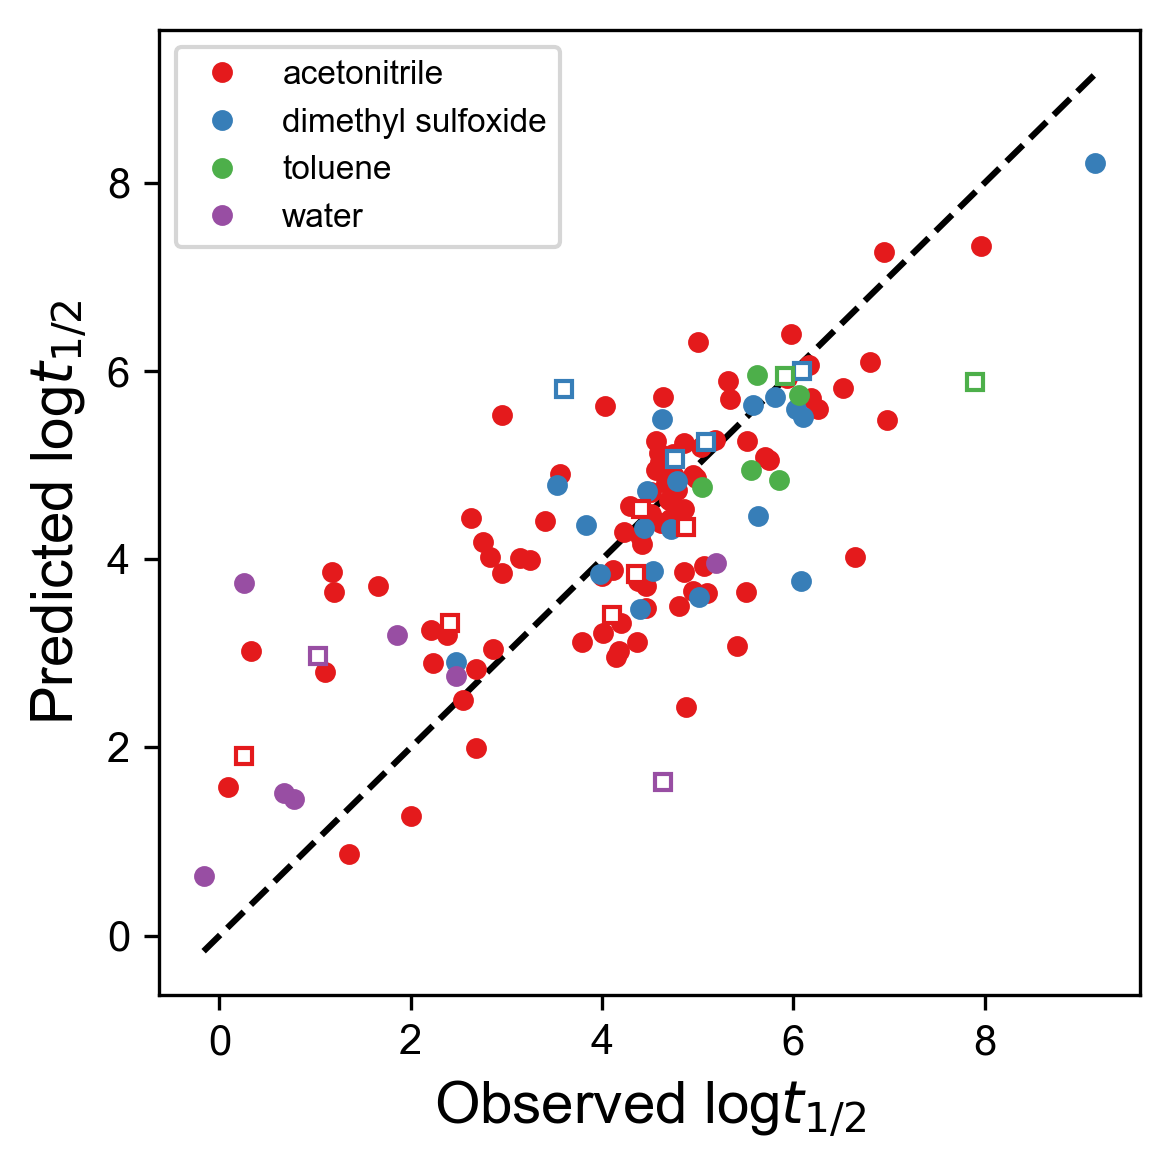

In [146]:
ext_preds = pd.read_table("Model files/SVR_Htime/predictions_Htime_bydescSVR.csv", sep=",")

obs = ext_preds["observed"]
pred_chyline = ext_preds["predicted_chyline"]

solvent_colors = {"acetonitrile":0, "dimethyl sulfoxide":1, "toluene":2, "water":3}

best = pd.read_table('models/logt12 models/Model_logt12_chyline/trials.best', sep=' ').iloc[0].trial
cv_res = pd.read_table('models/logt12 models/Model_logt12_chyline/trial.'+str(best)+"/predictions", sep=' ')
a = cv_res["Htime.observed"]
b = cv_res[['Htime.predicted.repeat'+str(i) for i in range(1,11)]]

fig, ax = plt.subplots(figsize=(4, 4), dpi=300, facecolor="w")
ax.plot([a.min(), a.max()], [a.min(), a.max()], "k--")
ax.set_xlabel(r"Observed log$t_{1/2}$", fontsize=14)
ax.set_ylabel(r"Predicted log$t_{1/2}$", fontsize=14)
for g, i in fdata_log.loc[train_logt12].groupby(by="solvent").groups.items():
    indices = [fdata_log.loc[train_logt12].index.get_loc(id) for id in i]
    ax.plot(a[indices],b.mean(axis=1)[indices], "o", color=colors[solvent_colors[g]], markersize=4, label=g)
    print(g, len(indices), "RMSE =", rmse(a[indices],b.mean(axis=1)[indices]), ", R2 =", r2(a[indices],b.mean(axis=1)[indices]))

for g, i in fdata_log.loc[test_logt12].groupby(by="solvent").groups.items():
    indices = [fdata_log.loc[test_logt12].index.get_loc(id) for id in i]
    ax.plot(obs[indices], pred_chyline[indices], "s", markersize=4, markerfacecolor="w", color=colors[solvent_colors[g]])
    print(g, len(indices), "RMSE =", rmse(obs[indices], pred_chyline[indices]), ", R2 =", r2(obs[indices], pred_chyline[indices]))
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig("logt12_by_solvent.png")

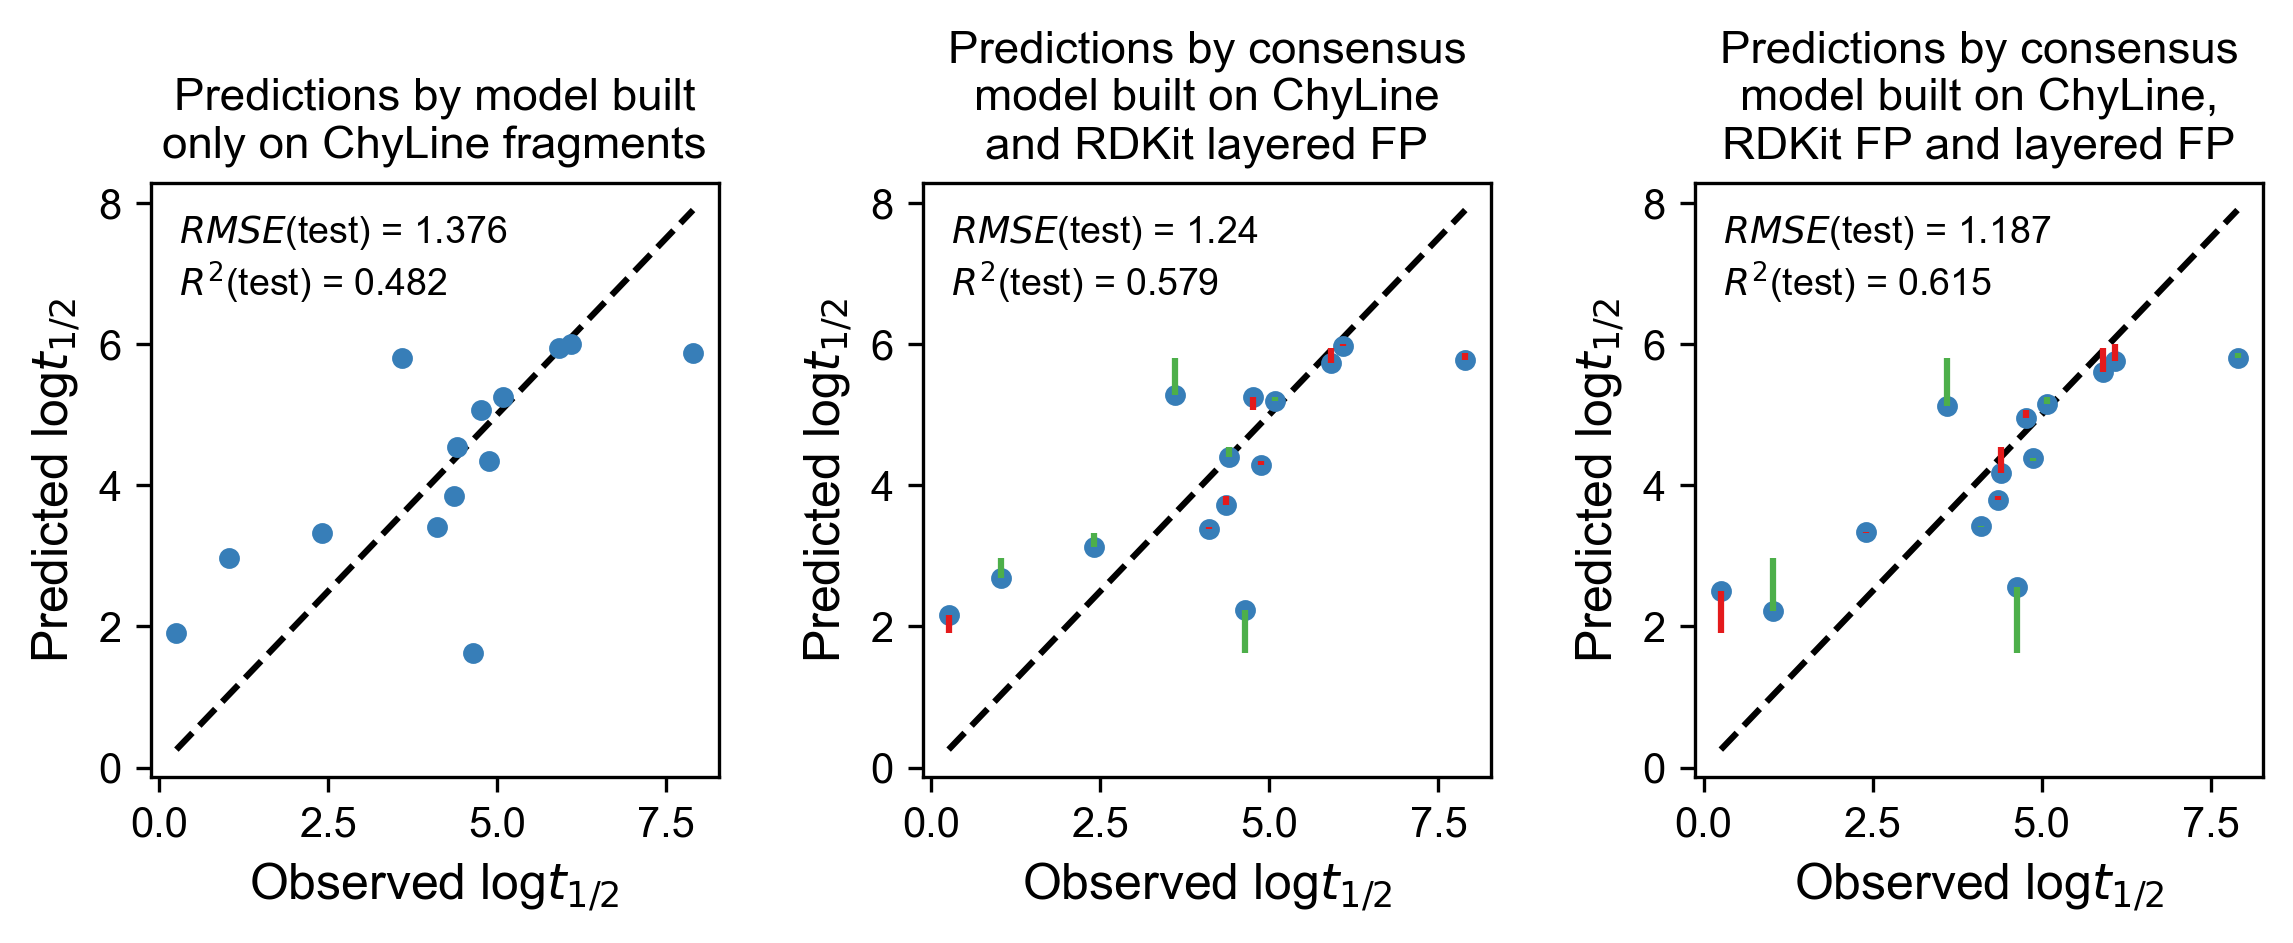

In [16]:
ext_preds = pd.read_table("Model files/SVR_Htime/predictions_Htime_bydescSVR.csv", sep=",")

obs = ext_preds["observed"]
pred_chyline = ext_preds["predicted_chyline"]
pred_layered = ext_preds["predicted_layered"]

#print(rmse(obs, ext_preds[["predicted_chyline", "predicted_layered"]].mean(axis=1)), 
#    r2(obs, ext_preds[["predicted_chyline", "predicted_layered"]].mean(axis=1)))

fig, ax = plt.subplots(1, 3, figsize=(8,3.5), dpi=300)
ax[0].plot([obs.min(), obs.max()], [obs.min(), obs.max()], "k--")
rms = rmse(ext_preds["observed"], ext_preds["predicted_chyline"])
ax[0].plot(ext_preds["observed"], ext_preds["predicted_chyline"], 'o', color=colors[1], markersize=4, 
        label="Only Chyline, "+str(np.round(rms, 3)))
textstr = r"$RMSE$(test) = " + str(round(rms, 3)) + "\n" 
textstr += r"$R^2$(test) = " + str(round(r2(ext_preds["observed"], ext_preds["predicted_chyline"]), 3))
ax[0].text(0.05, 0.95, textstr, transform=ax[0].transAxes,
                       fontsize=9, color='k',
                       verticalalignment="top", horizontalalignment="left",
                       bbox={"boxstyle":"round", "facecolor":"white", "alpha":0})

rms = rmse(ext_preds["observed"], ext_preds[["predicted_chyline", "predicted_layered"]].mean(axis=1))
ax[1].plot([obs.min(), obs.max()], [obs.min(), obs.max()], "k--")
ax[1].plot(ext_preds["observed"], ext_preds[["predicted_chyline", "predicted_layered"]].mean(axis=1), 'o', 
            color=colors[1], markersize=4, label="Chyline+layered, "+str(np.round(rms, 3)))
improve = np.abs(ext_preds["observed"]-ext_preds["predicted_chyline"])< np.abs(ext_preds["observed"]-ext_preds[["predicted_chyline", "predicted_layered"]].mean(axis=1))
ax[1].vlines(ext_preds["observed"], ymin=ext_preds["predicted_chyline"], 
             ymax=ext_preds[["predicted_chyline", "predicted_layered"]].mean(axis=1),
             colors=[colors[0] if i else colors[2] for i in improve ])
textstr = r"$RMSE$(test) = " + str(round(rms, 3)) + "\n" 
textstr += r"$R^2$(test) = " + str(round(r2(ext_preds["observed"], ext_preds[["predicted_chyline", "predicted_layered"]].mean(axis=1)), 3))
ax[1].text(0.05, 0.95, textstr, transform=ax[1].transAxes,
                       fontsize=9, color='k',
                       verticalalignment="top", horizontalalignment="left",
                       bbox={"boxstyle":"round", "facecolor":"white", "alpha":0})


rms = rmse(ext_preds["observed"], ext_preds[["predicted_chyline", "predicted_rdkfp", "predicted_layered"]].mean(axis=1))
ax[2].plot([obs.min(), obs.max()], [obs.min(), obs.max()], "k--")
ax[2].plot(ext_preds["observed"], ext_preds[["predicted_chyline", "predicted_rdkfp", "predicted_layered"]].mean(axis=1), 'o', 
           color=colors[1], markersize=4, label="Chyline+RDK linear+layered, "+str(np.round(rms, 3)))
improve = np.abs(ext_preds["observed"]-ext_preds["predicted_chyline"])< np.abs(ext_preds["observed"]-ext_preds[["predicted_chyline", "predicted_rdkfplinear", "predicted_layered"]].mean(axis=1))
ax[2].vlines(ext_preds["observed"], ymin=ext_preds["predicted_chyline"], 
             ymax=ext_preds[["predicted_chyline", "predicted_rdkfp", "predicted_layered"]].mean(axis=1),
             colors=[colors[0] if i else colors[2] for i in improve ])
textstr = r"$RMSE$(test) = " + str(round(rms, 3)) + "\n" 
textstr += r"$R^2$(test) = " + str(round(r2(ext_preds["observed"], 
                                            ext_preds[["predicted_chyline", "predicted_rdkfp", "predicted_layered"]].mean(axis=1)),
                                            3))
ax[2].text(0.05, 0.95, textstr, transform=ax[2].transAxes,
                       fontsize=9, color='k',
                       verticalalignment="top", horizontalalignment="left",
                       bbox={"boxstyle":"round", "facecolor":"white", "alpha":0})

ax[0].set_xlabel(r"Observed log$t_{1/2}$", fontsize=12)
ax[0].set_ylabel(r"Predicted log$t_{1/2}$", fontsize=12)
ax[0].set_title("Predictions by model built\nonly on ChyLine fragments", fontsize=11)
ax[1].set_xlabel(r"Observed log$t_{1/2}$", fontsize=12)
ax[1].set_ylabel(r"Predicted log$t_{1/2}$", fontsize=12)
ax[1].set_title("Predictions by consensus\nmodel built on ChyLine\nand RDKit layered FP", fontsize=11)
ax[2].set_xlabel(r"Observed log$t_{1/2}$", fontsize=12)
ax[2].set_ylabel(r"Predicted log$t_{1/2}$", fontsize=12)
ax[2].set_title("Predictions by consensus\nmodel built on ChyLine,\nRDKit FP and layered FP", fontsize=11)
plt.tight_layout(pad=2)
#plt.savefig("consensus modeling logt12.png", dpi=300)

In [ ]:
rms = rmse(ext_preds["observed"], ext_preds["predicted_chyline"])
rr = r2(ext_preds["observed"], ext_preds["predicted_chyline"])
print("Base", rms, rr)

for c in ['predicted_torsion', 'predicted_layered',
       'predicted_circus', 'predicted_morgan', 'predicted_rdkfp',
       'predicted_atompairs', 'predicted_avalon',
       'predicted_morganfeatures', 'predicted_rdkfplinear']:
    rms = rmse(ext_preds["observed"], ext_preds[["predicted_chyline", c]].mean(axis=1))
    rr = r2(ext_preds["observed"], ext_preds[["predicted_chyline", c]].mean(axis=1))
    print(c, rms, rr)

print()
for c in ['predicted_torsion', 'predicted_layered',
       'predicted_circus', 'predicted_morgan', 
       'predicted_atompairs', 'predicted_avalon',
       'predicted_morganfeatures', 'predicted_rdkfplinear']:
    rms = rmse(ext_preds["observed"], ext_preds[["predicted_chyline", 'predicted_rdkfp', c]].mean(axis=1))
    rr = r2(ext_preds["observed"], ext_preds[["predicted_chyline", 'predicted_rdkfp', c]].mean(axis=1))
    print(c, rms, rr)

## External predictions by best models

The following code is for reading, retraining and reapplying the best model obtained in the benchmark for each descriptor type.
The results of the predicitons are already available in the correspoiding folder as a CSV, so technically this code is not required, it is given to demonstrate how a saved model may be reused. Please note that the scikit-learn version 1.2.2 was used for training the models initially, and using any other version may lead to slightly different results.

In [ ]:
names_models = {'rdkfp':'Model files/SVR_lambda/SVR_trial396_Rdkfp_1024_4.pkl',
         'layered':'Model files/SVR_lambda/SVR_trial497_Layered_1024_6.pkl',
         'chyline':'Model files/SVR_lambda/SVR_trial24_Chyline_2_8.pkl',
         'morgan':'Model files/SVR_lambda/SVR_trial421_Morgan_1024_2.pkl',
         'circus':'Model files/SVR_lambda/SVR_trial126_Circus_0_2.pkl',
         'rdkfplinear':'Model files/SVR_lambda/SVR_trial335_Rdkfplinear_1024_8.pkl',
         'atompairs':'Model files/SVR_lambda/SVR_trial320_Atompairs_1024.pkl',
         'morganfeatures':'Model files/SVR_lambda/SVR_trial244_Morganfeatures_1024_3.pkl',
         'avalon':'Model files/SVR_lambda/SVR_trial197_Avalon_1024.pkl'}

predictions_table = pd.DataFrame(columns=["observed"])
predictions_table["observed"] = np.array(fdata_lambda.loc[test_lambda]["lambda"])

for i, dtype in enumerate(["circus", "chyline", "avalon", "morgan", 'morganfeatures', 'atompairs', 
                           "rdkfp", "rdkfplinear", 'layered']):
    with open(names_models[dtype], "rb") as f:
        model = pickle.load(f)
    model.fit(fdata_lambda.loc[train_lambda]["mol"], fdata_lambda.loc[train_lambda]["lambda"])
    preds = model.predict(fdata_lambda.loc[test_lambda]["mol"])
    predictions_table["predicted_"+dtype] = preds
    print(dtype, r2(fdata_lambda.loc[test_lambda]["lambda"], preds))

predictions_table

## Comparison of methods in the benchmark

In [ ]:
names_svm = {'RDKFP':'models/Model_lambda_rdkfp',
         'RDKFP layered':'models/Model_lambda_layered',
         'ChyLine':'models/Model_lambda_chyline',
         'Morgan':'models/Model_lambda_morgan',
         'CircuS':'models/Model_lambda_circus',
         'RDKFP linear':'models/Model_lambda_rdkfplinear',
         'AtomPairs':'models/Model_lambda_atompairs',
         'Morgan features':'models/Model_lambda_morganfeatures',
         'Avalon':'models/Model_lambda_avalon'}

names_rfr = {'RDKFP':'models/Model_lambda_rdkfpRFR',
         'RDKFP layered':'models/Model_lambda_layeredRFR',
         'ChyLine':'models/Model_lambda_chylineRFR',
         'Morgan':'models/Model_lambda_morganRFR',
         'CircuS':'models/Model_lambda_circusRFR',
         'RDKFP linear':'models/Model_lambda_rdkfplinearRFR',
         'AtomPairs':'models/Model_lambda_atompairsRFR',
         'Morgan features':'models/Model_lambda_morganfeaturesRFR',
         'Avalon':'models/Model_lambda_avalonRFR'}

names_xgb = {'RDKFP':'models/Model_lambda_rdkfpXG',
         'RDKFP layered':'models/Model_lambda_layeredXG',
         'ChyLine':'models/Model_lambda_chylineXG',
         'Morgan':'models/Model_lambda_morganXG',
         'CircuS':'models/Model_lambda_circusXG',
         'RDKFP linear':'models/Model_lambda_rdkfplinearXG',
         'AtomPairs':'models/Model_lambda_atompairsXG',
         'Morgan features':'models/Model_lambda_morganfeaturesXG',
         'Avalon':'models/Model_lambda_avalonXG'}

r2_svm = []
r2_rfr = []
r2_xgb = []

for i, dtype in enumerate(["CircuS", "ChyLine", "Avalon", "Morgan", 'Morgan features', 'AtomPairs', 
                           "RDKFP", "RDKFP linear", 'RDKFP layered']):
    d = dtype.lower()

    best = pd.read_table(names_svm[dtype]+'/trials.best', sep=' ').iloc[0].trial
    cv_res = pd.read_table(names_svm[dtype]+"/trial."+str(best)+"/predictions", sep=' ')
    a = cv_res["lambdaa.observed"]
    b = cv_res[['lambdaa.predicted.repeat'+str(i) for i in range(1,11)]]
    r2_svm.append(r2(a, b.mean(axis=1))) 

    best = pd.read_table(names_rfr[dtype]+'/trials.best', sep=' ').iloc[0].trial
    cv_res = pd.read_table(names_rfr[dtype]+"/trial."+str(best)+"/predictions", sep=' ')
    a = cv_res["lambdaa.observed"]
    b = cv_res[['lambdaa.predicted.repeat'+str(i) for i in range(1,11)]]
    r2_rfr.append(r2(a, b.mean(axis=1))) 

    best = pd.read_table(names_xgb[dtype]+'/trials.best', sep=' ').iloc[0].trial
    cv_res = pd.read_table(names_xgb[dtype]+"/trial."+str(best)+"/predictions", sep=' ')
    a = cv_res["lambdaa.observed"]
    b = cv_res[['lambdaa.predicted.repeat'+str(i) for i in range(1,11)]]
    r2_xgb.append(r2(a, b.mean(axis=1))) 

fig, ax = plt.subplots(figsize = (7,4), dpi=300, facecolor="w")
ax.plot([0,1,2,3,4,5,6,7,8], r2_svm, "o-", color=colors[0], label="SVM")
ax.plot([0,1,2,3,4,5,6,7,8], r2_rfr, "o-", color=colors[1], label="RF")
ax.plot([0,1,2,3,4,5,6,7,8], r2_xgb, "o-", color=colors[2], label="XGB")

ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
ax.set_xticklabels(["CircuS", "ChyLine", "Avalon", "Morgan", 'Morgan features', 'AtomPairs', 
                           "RDKFP", "RDKFP linear", 'RDKFP layered'], 
                    rotation=-45, fontsize=14,
                    ha="right",rotation_mode="anchor")
ax.set_ylabel(r"$R^2$", fontsize=14, rotation=0, labelpad=15)#, loc="top")
#ax.set_ylim([0.75, 0.95])
ax.grid(color="lightgrey", axis="y", alpha=.5)
plt.legend()
plt.tight_layout()
#plt.savefig("comparison of methods on lambda.png", dpi=300)

# Visualization of chemical space

The following code reproduces the UMAP visualization of the chemical space for both property datasets. Please note that UMAP is stochastic in nature, and the resulting map may not be exactly as presented in the manuscript, even when using pretrained mappers (provided in the repository).

In [178]:
import umap
import numba
from doptools import ChythonCircus, ChythonLinear

def tanimoto_dist(a, b):
    return 1 - np.dot(a,b)/(np.dot(a,a) + np.dot(b,b) - np.dot(a,b))

lambda_fragmentor = ChythonCircus(0,2)
lambda_fragmentor.fit(fdata_lambda.loc[train_lambda]["mol"])

lambda_train_desc = lambda_fragmentor.transform(fdata_lambda.loc[train_lambda]["mol"])
lambda_test_desc = lambda_fragmentor.transform(fdata_lambda.loc[test_lambda]["mol"])

# === Following code is used for training the UMAP model. 
# === The models are pretrained in the manuscript, please find the pickle files in the repository
#lambda_umap_model = umap.UMAP(n_neighbors=25, min_dist=0.5, n_components=2, metric=tanimoto_dist)
#lambda_umap_model.fit(lambda_train_desc)
#with open('mapper.lambda.pkl', 'wb') as f:
#    pickle.dump(lambda_umap_model, f, pickle.HIGHEST_PROTOCOL)
#lambda_umap_embedding = lambda_umap_model.transform(lambda_train_desc)
#lambda_test_embedding = lambda_umap_model.transform(lambda_test_desc)



In [ ]:
with open('mapper.lambda.pkl', 'rb') as f:
    lambda_umap_model = pickle.load(f)
lambda_umap_embedding = lambda_umap_model.transform(lambda_train_desc)
lambda_test_embedding = lambda_umap_model.transform(lambda_test_desc)

plt.figure(figsize=(4.5, 4), dpi=300)
plt.plot(lambda_umap_embedding[:, 0], lambda_umap_embedding[:, 1], "o", color=colors[0], markersize=3, label='training')
plt.plot(lambda_test_embedding[:, 0], lambda_test_embedding[:, 1], "o", color=colors[1], markersize=3, label='test')
plt.plot(lambda_test_embedding[[9, 26, 30, 35, 64], 0], lambda_test_embedding[[9, 26, 30, 35, 64], 1], "o", 
         color=colors[1], markeredgecolor="k", markersize=3)
plt.title(r'UMAP visualization of $\lambda_{max}$ chemical space')
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Dataset', )
plt.tight_layout()
#plt.savefig('chemical_space_lambda.png', dpi=300)

In [181]:
logt12_fragmentor = ChythonLinear(2,6)
logt12_fragmentor.fit(fdata_log.loc[train_logt12]["mol"])

logt12_train_desc = logt12_fragmentor.transform(fdata_log.loc[train_logt12]["mol"])
logt12_test_desc = logt12_fragmentor.transform(fdata_log.loc[test_logt12]["mol"])

# === Following code is used for training the UMAP model. 
# === The models are pretrained in the manuscript, please find the pickle files in the repository
#logt12_umap_model = umap.UMAP(n_neighbors=25, min_dist=0.5, n_components=2, metric=tanimoto_dist)
#logt12_umap_model.fit(logt12_train_desc)
#with open('mapper.logt12.pkl', 'wb') as f:
#    pickle.dump(logt12_umap_model, f, pickle.HIGHEST_PROTOCOL)
#logt12_umap_embedding = logt12_umap_model.transform(logt12_train_desc)
#logt12_test_embedding = logt12_umap_model.transform(logt12_test_desc)



/Users/pavel/anaconda3/envs/py310/lib/python3.10/site-packages/umap/umap_.py:1850: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


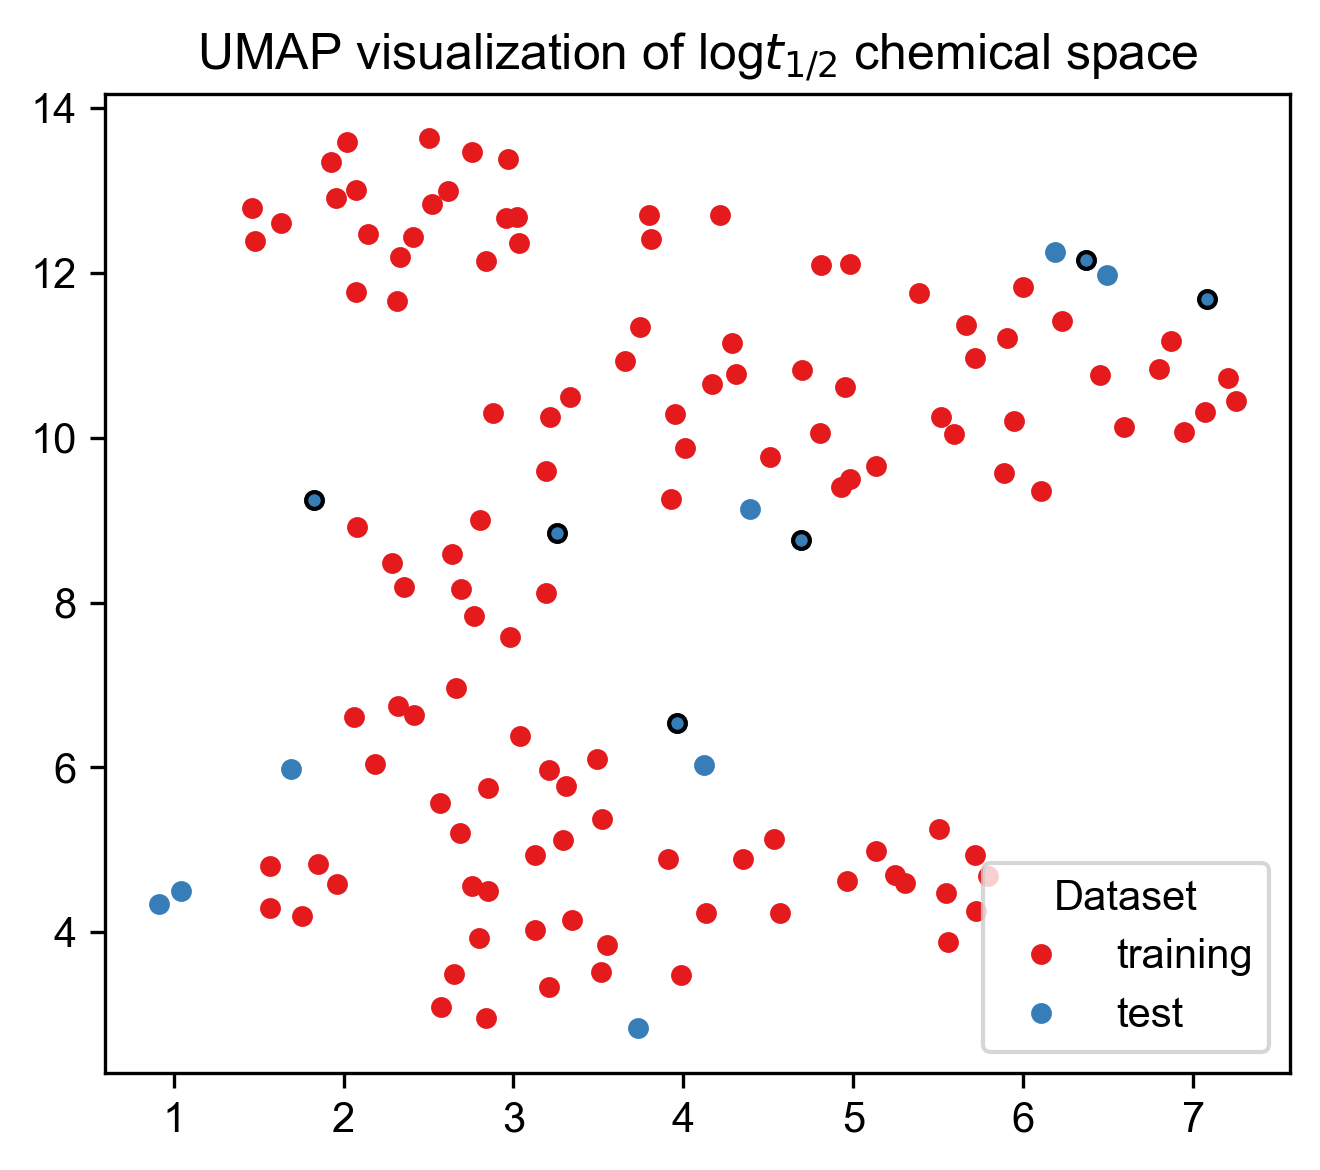

In [189]:
#with open('mapper.logt12.pkl', 'rb') as f:
#    logt12_umap_model = pickle.load(f)
#logt12_umap_embedding = logt12_umap_model.transform(logt12_train_desc)
#logt12_test_embedding = logt12_umap_model.transform(logt12_test_desc)

plt.figure(figsize=(4.5, 4), dpi=300)
plt.plot(logt12_umap_embedding[:, 0], logt12_umap_embedding[:, 1], "o", color=colors[0], markersize=4, label='training')
plt.plot(logt12_test_embedding[:, 0], logt12_test_embedding[:, 1], "o", color=colors[1], markersize=4, label='test')
plt.plot(logt12_test_embedding[[9,13,1,8,6,11], 0], logt12_test_embedding[[9,13,1,8,6,11], 1], "o", 
         color=colors[1], markeredgecolor="k", markersize=4)
plt.title(r'UMAP visualization of log$t_{1/2}$ chemical space')
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Dataset', )
plt.tight_layout()
plt.savefig('chemical_space_logt12.png', dpi=300)

In [188]:
logt12_test_embedding[[9,13,1,8,6,11]]

array([[ 6.366933 , 12.160813 ],
       [ 7.079972 , 11.683539 ],
       [ 3.253138 ,  8.840006 ],
       [ 4.691348 ,  8.764155 ],
       [ 1.8236951,  9.247647 ],
       [ 3.962448 ,  6.5437436]], dtype=float32)

# Model interpretation

The following code visulaizes the ColorAtom representations for the model predicting the half-life.

In [18]:
from pandas import Series
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from doptools import ColorAtom
from IPython.display import HTML, display

RWB = LinearSegmentedColormap.from_list("RWB", ["#0571b0","#92c5de","#f7f7f7","#f4a582","#ca0020"])

ca = ColorAtom(colormap=RWB)

with open("Model files/SVR_Htime/SVR_trial57_chyline_2_6.pkl", "rb") as f:
    model = pickle.load(f)
model.fit(fdata_log.loc[train_logt12]["mol"], fdata_log.loc[train_logt12]["logt12"])

ca.set_pipeline(model)

contr = []
indices = [12,13,1,8,4]
for i in indices:
    m = fdata_log["mol"].loc[test_logt12[i]]
    contr += [v for v in ca.calculate_atom_contributions(m)[m].values()]

max_value = np.max(np.abs(contr))

for i in indices:
    svgs = ca._draw_one_molecule(fdata_log["mol"].loc[test_logt12[i]], colorbar=True, external_limits=[-max_value, max_value])
    no_wrap_div = '<div style="white-space: nowrap; align-items: middle">'+'{}'*len(svgs)+'</div>'
    display(HTML(no_wrap_div.format(*svgs)))

/Users/pavel/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator VarianceThreshold from version 1.5.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/pavel/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVR from version 1.5.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/pavel/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.5.0 when us

In [23]:
ca_lambda = ColorAtom(colormap=RWB)

with open("Model files/SVR_lambda/SVR_trial126_Circus_0_2.pkl", "rb") as f:
    model_lambda = pickle.load(f)
model_lambda.fit(fdata_lambda.loc[train_lambda]["mol"], fdata_lambda.loc[train_lambda]["lambda"])

ca_lambda.set_pipeline(model_lambda)

contr_lambda = []
indices_lambda = [35, 30, 64, 9, 26]
for i in indices_lambda:
    m = fdata_lambda["mol"].loc[test_lambda[i]]
    contr_lambda += [v for v in ca_lambda.calculate_atom_contributions(m)[m].values()]

max_value_lambda = np.max(np.abs(contr_lambda))

for i in indices_lambda:
    svgs = ca_lambda._draw_one_molecule(fdata_lambda["mol"].loc[test_lambda[i]], colorbar=True, 
                                        external_limits=[-max_value_lambda, max_value_lambda])
    no_wrap_div = '<div style="white-space: nowrap; align-items: middle">'+'{}'*len(svgs)+'</div>'
    display(HTML(no_wrap_div.format(*svgs)))

/Users/pavel/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator VarianceThreshold from version 1.5.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/pavel/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVR from version 1.5.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/pavel/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.5.0 when us

### Alternative models (train and test separation by clustering)

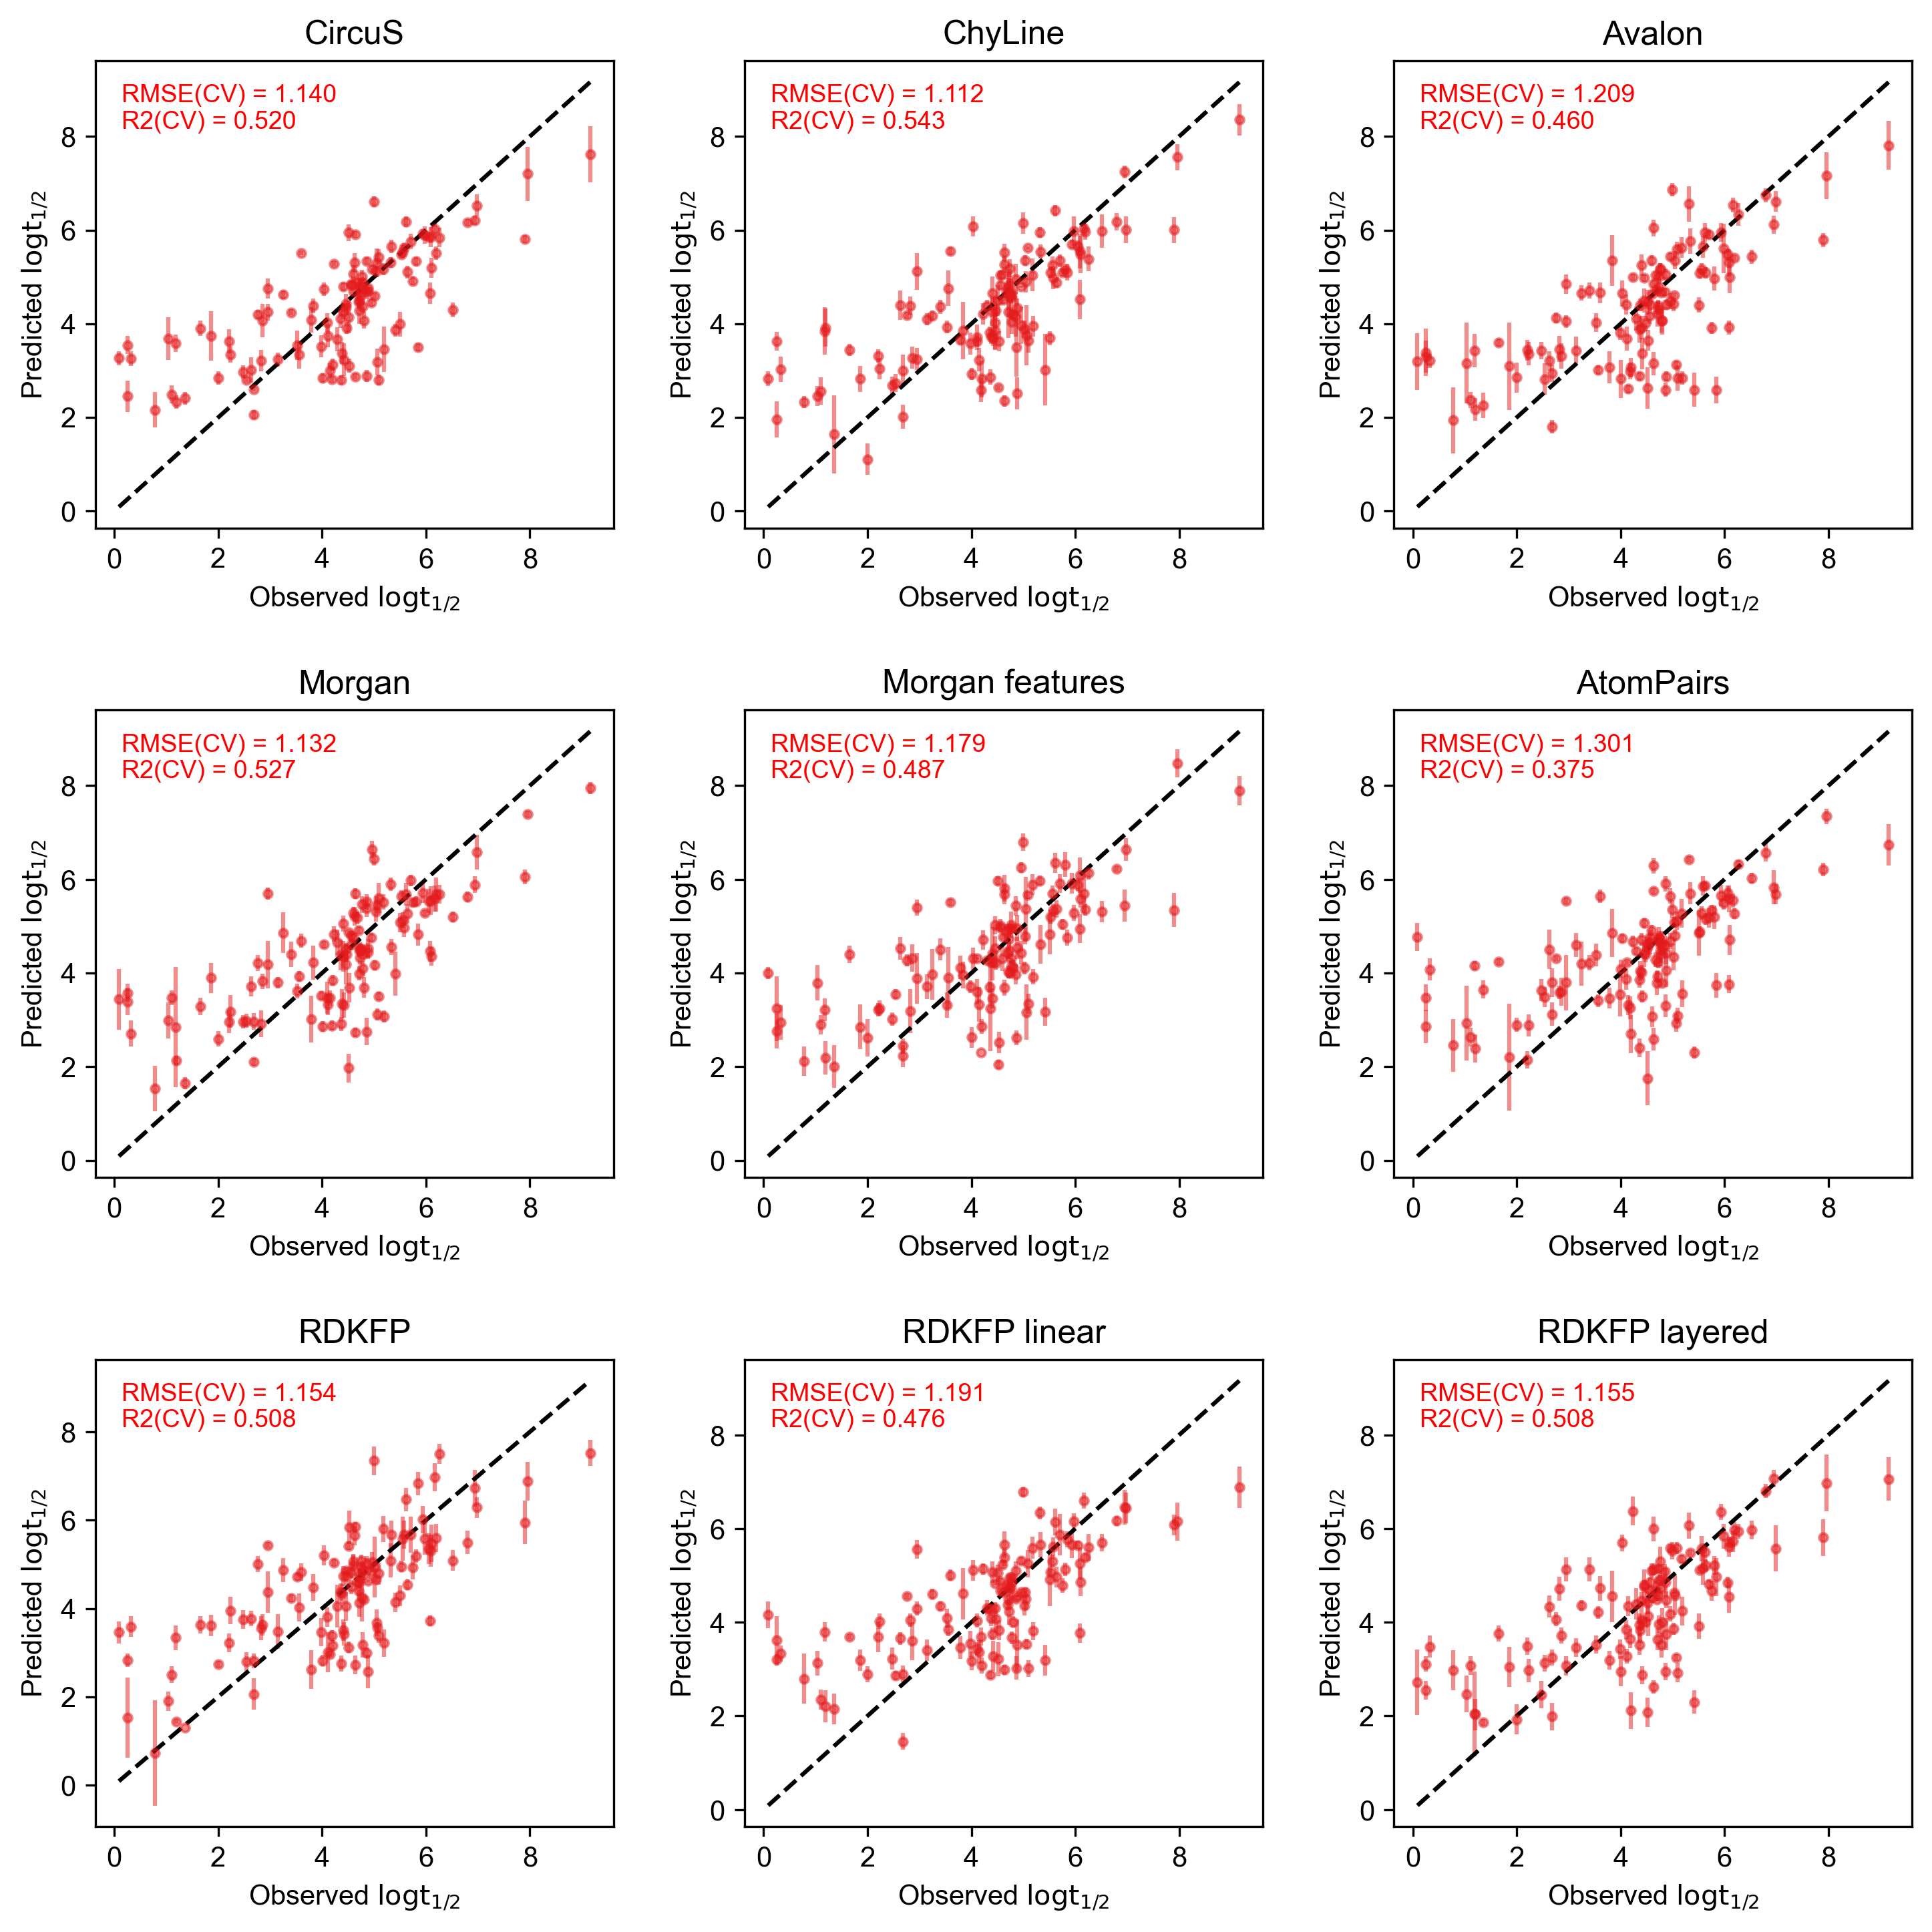

In [193]:

names = {'RDKFP':'models/logt12 Models/clustering_clean/Model_rdkfp',
         'RDKFP layered':'models/logt12 Models/clustering_clean/Model_layered',
         'ChyLine':'models/logt12 Models/clustering_clean/Model_chyline',
         'Morgan':'models/logt12 Models/clustering_clean/Model_morgan',
         'CircuS':'models/logt12 Models/clustering_clean/Model_circus',
         'RDKFP linear':'models/logt12 Models/clustering_clean/Model_rdkfplinear',
         'AtomPairs':'models/logt12 Models/clustering_clean/Model_atompairs',
         'Morgan features':'models/logt12 Models/clustering_clean/Model_morganfeatures',
         'Avalon':'models/logt12 Models/clustering_clean/Model_avalon'}

fig, ax = plt.subplots(3, 3, figsize=(10,10), dpi=300, facecolor="white")

for i, dtype in enumerate(["CircuS", "ChyLine", "Avalon", "Morgan", 'Morgan features', 'AtomPairs', 
                           "RDKFP", "RDKFP linear", 'RDKFP layered']):
    d = dtype.lower()

    best = pd.read_table(names[dtype]+'/trials.best', sep=' ').iloc[0].trial
    cv_res = pd.read_table(names[dtype]+"/trial."+str(best)+"/predictions", sep=' ')
    a = cv_res["logt12.observed"]
    b = cv_res[['logt12.predicted.repeat'+str(i) for i in range(1,11)]]

    fdata_logt12 = fdata[pd.notnull(fdata.logt12)]
    fdata_logt12 = fdata_logt12.reset_index()
    ind_switches = fdata_logt12[fdata_logt12.subset == 'switches'].index
    ind_double = fdata_logt12[fdata_logt12.subset == 'double_prop'].index

    ax[i//3, i%3].errorbar(a,b.mean(axis=1),
                           b.std(axis=1), fmt=".", color=colors[0], alpha=0.5)
    
    ax[i//3, i%3].plot([a.min(), a.max()], [a.min(), a.max()], "k--")
    ax[i//3, i%3].set_xlabel(r"Observed $\rm{log} t_{1/2}$")
    ax[i//3, i%3].set_ylabel(r"Predicted $\rm{log} t_{1/2}$")
    ax[i//3, i%3].set_title(dtype)

    textstr = "\n".join([
        "RMSE(CV) = %.3f"  % (rmse(a,b.mean(axis=1)), ),
        "R2(CV) = %.3f"  % (r2(a,b.mean(axis=1)), )
            ])
    ax[i//3, i%3].text(0.05, 0.95, textstr, transform=ax[i//3, i%3].transAxes,
                       fontsize=9, color='red',
                       verticalalignment="top", horizontalalignment="left",
                       bbox={"boxstyle":"round", "facecolor":"white", "alpha":0})
    
plt.tight_layout(pad=2)

1.4675214879423673


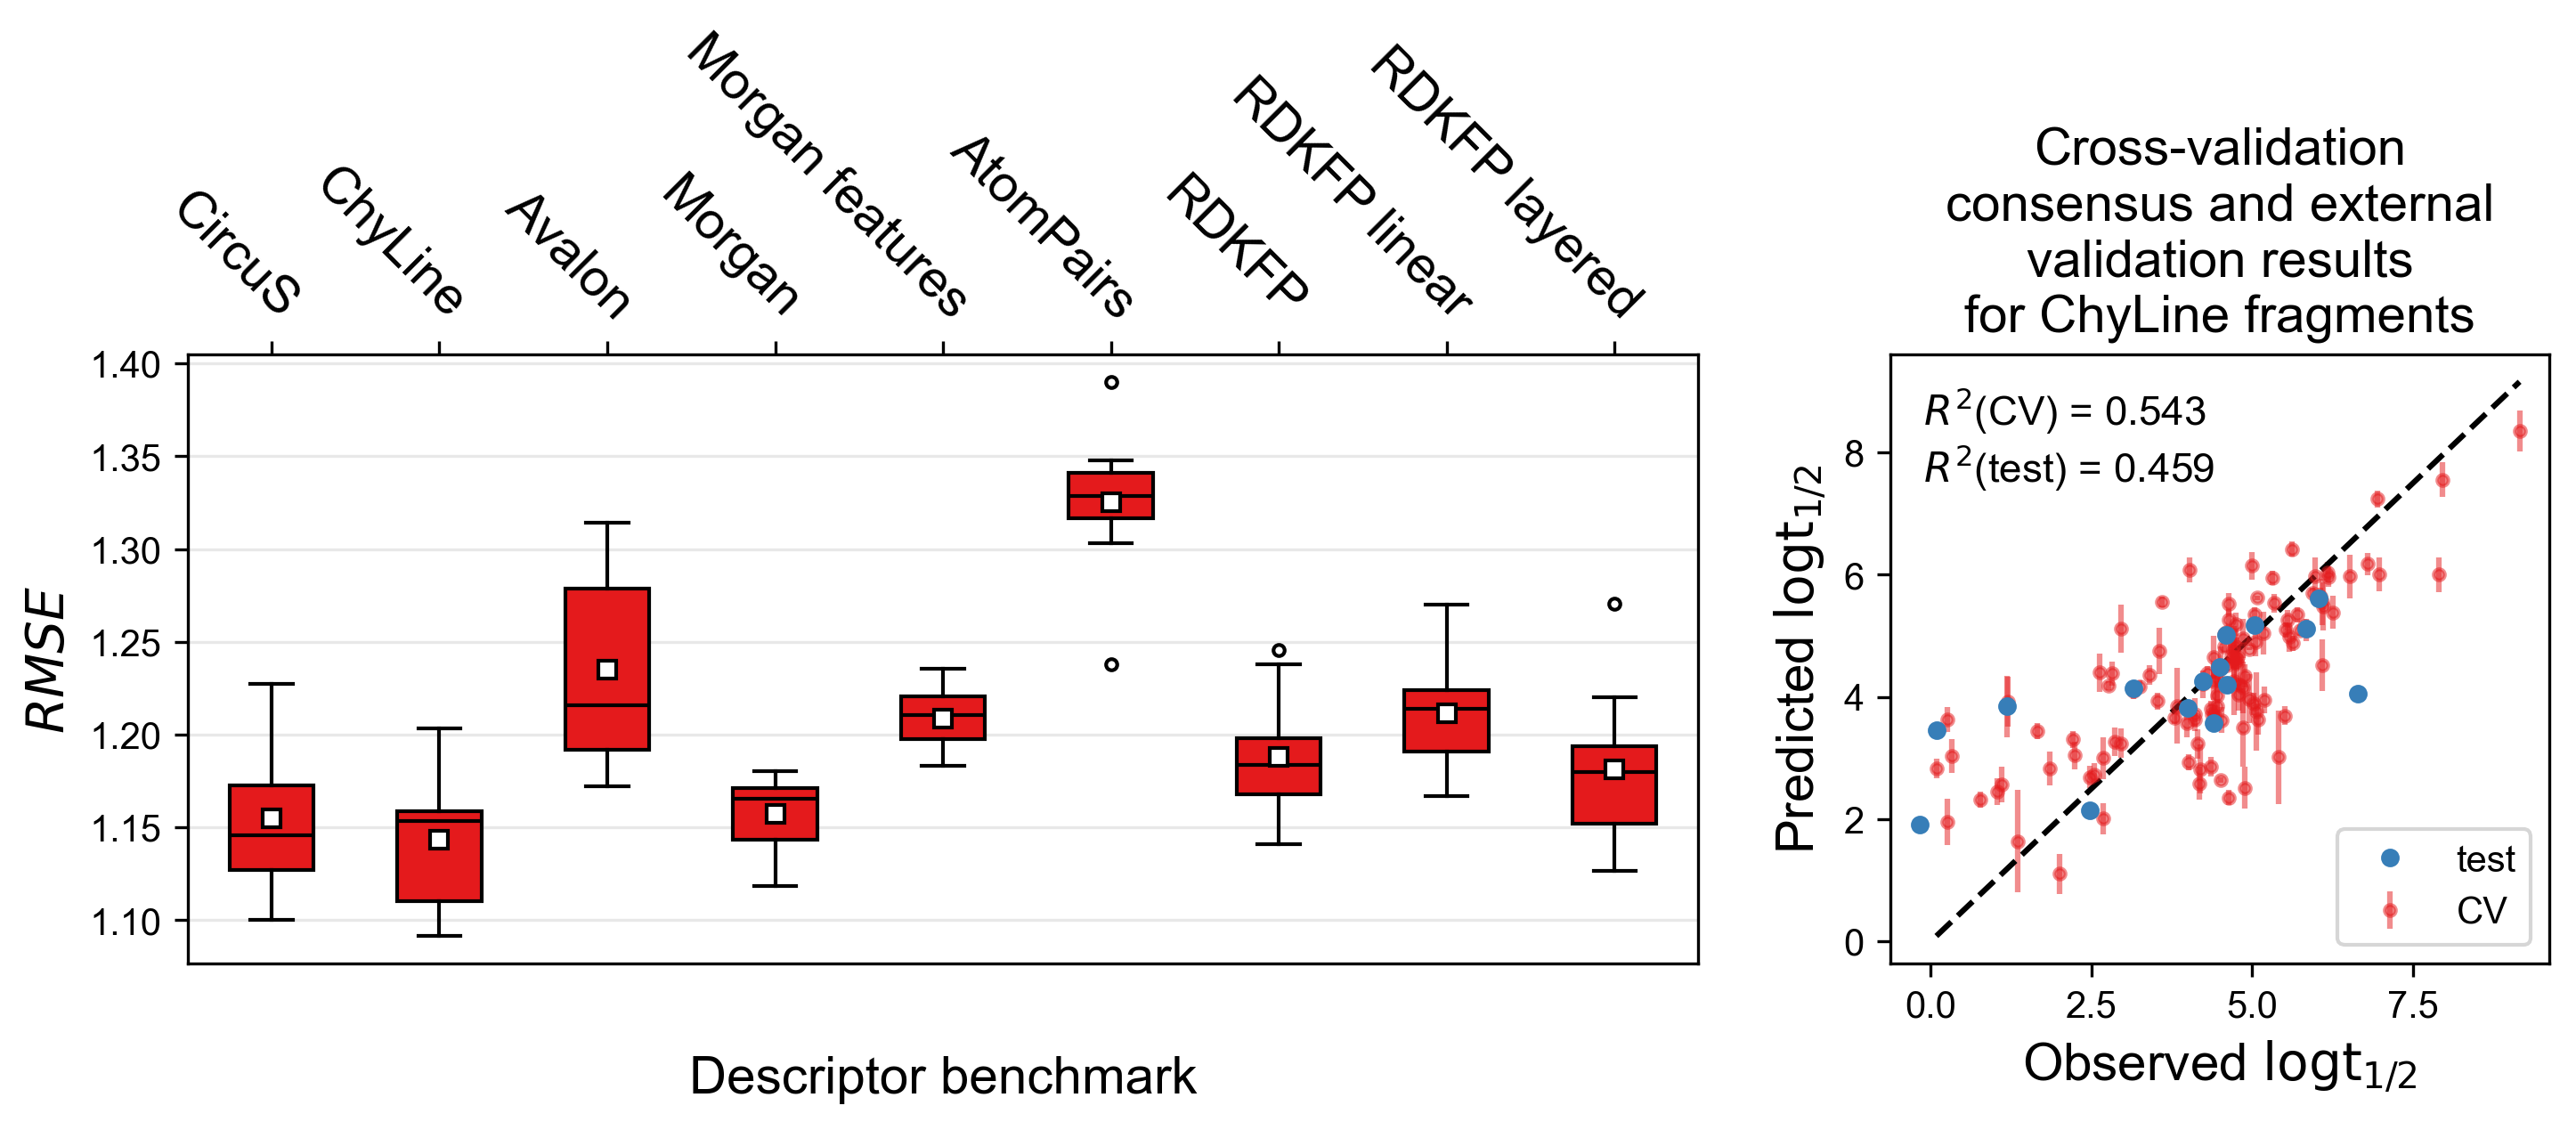

In [194]:
names = {'RDKFP':'models/logt12 Models/clustering_clean/Model_rdkfp',
         'RDKFP layered':'models/logt12 Models/clustering_clean/Model_layered',
         'ChyLine':'models/logt12 Models/clustering_clean/Model_chyline',
         'Morgan':'models/logt12 Models/clustering_clean/Model_morgan',
         'CircuS':'models/logt12 Models/clustering_clean/Model_circus',
         'RDKFP linear':'models/logt12 Models/clustering_clean/Model_rdkfplinear',
         'AtomPairs':'models/logt12 Models/clustering_clean/Model_atompairs',
         'Morgan features':'models/logt12 Models/clustering_clean/Model_morganfeatures',
         'Avalon':'models/logt12 Models/clustering_clean/Model_avalon'}

fig = plt.figure(figsize = (10,4.8), dpi=300, facecolor="w")

ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 3), (0, 2))

cv_r2_results = []
for i, dtype in enumerate(["CircuS", "ChyLine", "Avalon", "Morgan", 'Morgan features', 'AtomPairs', 
                           "RDKFP", "RDKFP linear", 'RDKFP layered']):
    d = dtype.lower()
    cv_r2_results.append([])

    best = pd.read_table(names[dtype]+'/trials.best', sep=' ').iloc[0].trial
    cv_res = pd.read_table(names[dtype]+"/trial."+str(best)+"/predictions", sep=' ')
    a = cv_res["logt12.observed"]
    for i in range(1,11):
        b = cv_res['logt12.predicted.repeat'+str(i)]
        cv_r2_results[-1].append(rmse(a,b))

bp1 = ax1.boxplot(cv_r2_results, positions=[0,1,2,3,4,5,6,7,8],
                  patch_artist=True, showmeans=True)
for median in bp1['medians']:
    median.set(color='k', linewidth=1)
for mean in bp1['means']:
    mean.set(marker='s', markerfacecolor='w', markeredgecolor='k', markersize=5)
for item in ['boxes', 'whiskers', 'fliers', 'caps']:
        plt.setp(bp1[item], color='k')
plt.setp(bp1["boxes"], facecolor=colors[0], edgecolor='k')
plt.setp(bp1["fliers"], markeredgecolor='k', markersize=3)

ax1.set_xticks([0,1,2,3,4,5,6,7,8])
ax1.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
ax1.set_xticklabels(["CircuS", "ChyLine", "Avalon", "Morgan", 'Morgan features', 'AtomPairs', 
                           "RDKFP", "RDKFP linear", 'RDKFP layered'], 
                    rotation=-45, fontsize=14,
                    ha="right",rotation_mode="anchor")
ax1.set_ylabel(r"$RMSE$", fontsize=14)#, rotation=0, labelpad=-15, loc="top")
#ax.set_ylim([0.75, 0.95])
ax1.grid(color="lightgrey", axis="y", alpha=.5)
ax1.text(0.5, -0.15, 'Descriptor benchmark', transform=ax1.transAxes,
                       fontsize=14, color='k',
                       verticalalignment="top", horizontalalignment="center")

best_regr = pd.read_table(names["ChyLine"]+'/trials.best', sep=' ').iloc[0]

from doptools.cli.rebuilder import rebuild_from_file

pipeline, trial = rebuild_from_file("models/logt12 Models/clustering_clean/desc/chyline", 
                                    names["ChyLine"], best_regr["trial"])
pipeline.fit(train_logt12_clustering["mol"], train_logt12_clustering["logt12"])
cv_res = pd.read_table(names['ChyLine']+"/trial."+str(best_regr["trial"])+"/predictions", sep=' ')
a = cv_res["logt12.observed"]
b = cv_res[['logt12.predicted.repeat'+str(i) for i in range(1,11)]]
    
ax2.errorbar(a,b.mean(axis=1), b.std(axis=1), fmt=".", color=colors[0], alpha=0.5, label="CV")
    
ax2.plot([a.min(), a.max()], [a.min(), a.max()], "k--")

ext_preds = pipeline.predict(test_logt12_clustering["mol"])

ax2.plot(test_logt12_clustering["logt12"], ext_preds, 'o', color=colors[1], markersize=4,  zorder=10, label="test")
ax2.set_xlabel(r"Observed $\rm{log} t_{1/2}$", fontsize=14)
ax2.set_ylabel(r"Predicted $\rm{log} t_{1/2}$", fontsize=14)
ax2.set_title('Cross-validation\nconsensus and external\nvalidation results\nfor ChyLine fragments', fontsize=14)
#textstr = r"$RMSE$(CV) = " + str(round(rmse(a,b.mean(axis=1)),2)) + '\n' + 
print(rmse(test_logt12_clustering["logt12"], ext_preds))
textstr = r"$R^2$(CV) = " + str(round(r2(a,b.mean(axis=1)), 3))
textstr += '\n' + r"$R^2$(test) = " + str(round(r2(test_logt12_clustering["logt12"], ext_preds), 3))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes,
                       fontsize=11, color='k',
                       verticalalignment="top", horizontalalignment="left",
                       bbox={"boxstyle":"round", "facecolor":"white", "alpha":0})

ax2.legend(loc=4)
plt.tight_layout(pad=2)
plt.savefig("Benchmark logt12 - alternative test set.png", dpi=300)

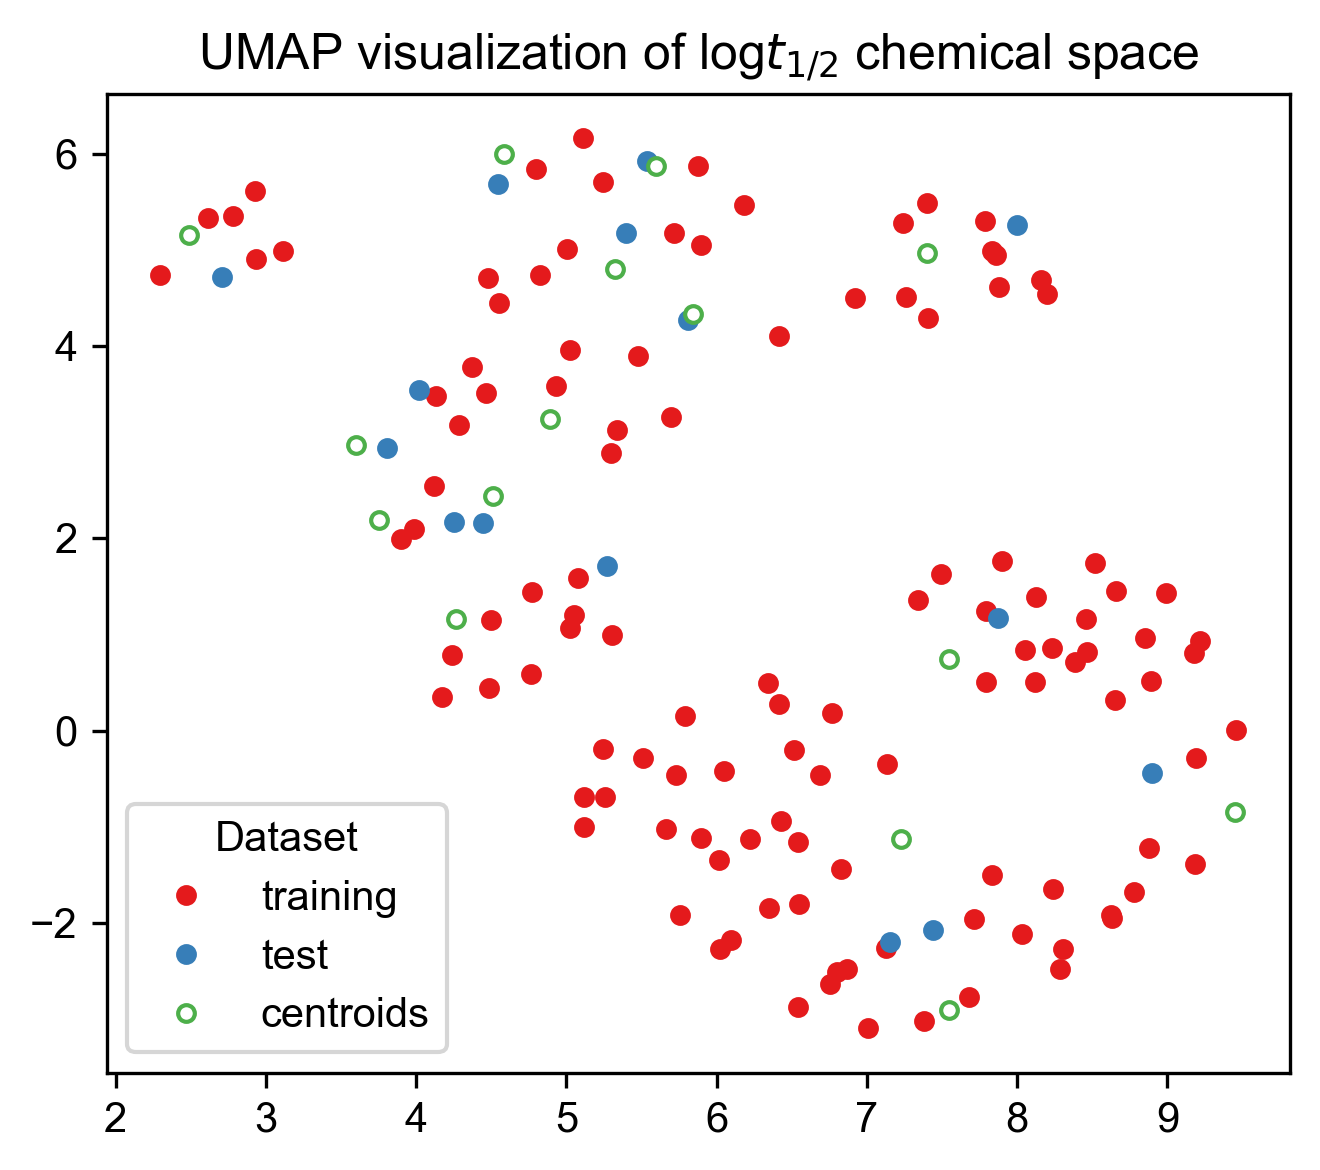

In [109]:
import umap

clustering_fragmentor = ChythonLinear(2, 6)
clustering_fragmentor.fit(fdata_log["mol"])
clustering_desc = clustering_fragmentor.transform(fdata_log["mol"])

clustering_desc = pd.concat([clustering_desc, pd.DataFrame(kmeans.cluster_centers_, columns=clustering_desc.columns)])

clustering_train_desc = clustering_fragmentor.transform(train_logt12_clustering["mol"])
clustering_test_desc = clustering_fragmentor.transform(test_logt12_clustering["mol"])

clustering_umap_model = umap.UMAP(n_neighbors=25, min_dist=0.5, n_components=2, metric="euclidean")
clustering_umap_model.fit(clustering_desc)
clustering_full_embedding = clustering_umap_model.transform(clustering_desc)
clustering_umap_embedding = clustering_umap_model.transform(clustering_train_desc)
clustering_test_embedding = clustering_umap_model.transform(clustering_test_desc)
centroids_embedding = clustering_umap_model.transform(kmeans.cluster_centers_)

plt.figure(figsize=(4.5, 4), dpi=300)
plt.plot(clustering_full_embedding[np.where(np.argsort(list(train_logt12_clustering.index)+list(test_logt12_clustering.index))<=118)[0], 0], 
         clustering_full_embedding[np.where(np.argsort(list(train_logt12_clustering.index)+list(test_logt12_clustering.index))<=118)[0], 1], "o", 
         color=colors[0], markersize=4, label='training')
plt.plot(clustering_full_embedding[np.where(np.argsort(list(train_logt12_clustering.index)+list(test_logt12_clustering.index))>118)[0], 0], 
         clustering_full_embedding[np.where(np.argsort(list(train_logt12_clustering.index)+list(test_logt12_clustering.index))>118)[0], 1], "o", 
         color=colors[1], markersize=4, label='test')
plt.plot(clustering_full_embedding[-15:, 0], 
         clustering_full_embedding[-15:, 1], "o", 
         color=colors[2], markersize=4, markerfacecolor="w", label='centroids')
#plt.plot(clustering_test_embedding[[1,4,8,12,13], 0], clustering_test_embedding[[1,4,8,12,13], 1], "o", 
#         color=colors[1], markeredgecolor="k", markersize=4)
plt.title(r'UMAP visualization of log$t_{1/2}$ chemical space')
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Dataset', )
plt.tight_layout()
plt.savefig("umap alternative logt12+centroids.png", dpi=300)

In [103]:
unique, counts = np.unique(distances.argmin(axis=1), return_counts=True)
dict(zip(unique, counts))

{0: 44,
 1: 2,
 2: 12,
 3: 6,
 4: 7,
 5: 11,
 6: 11,
 7: 1,
 8: 7,
 9: 3,
 10: 21,
 11: 2,
 12: 5,
 13: 1,
 14: 1}

### Testing on isolated solvent (acetonitrile)


0.9774128955421516
1.19502022799173


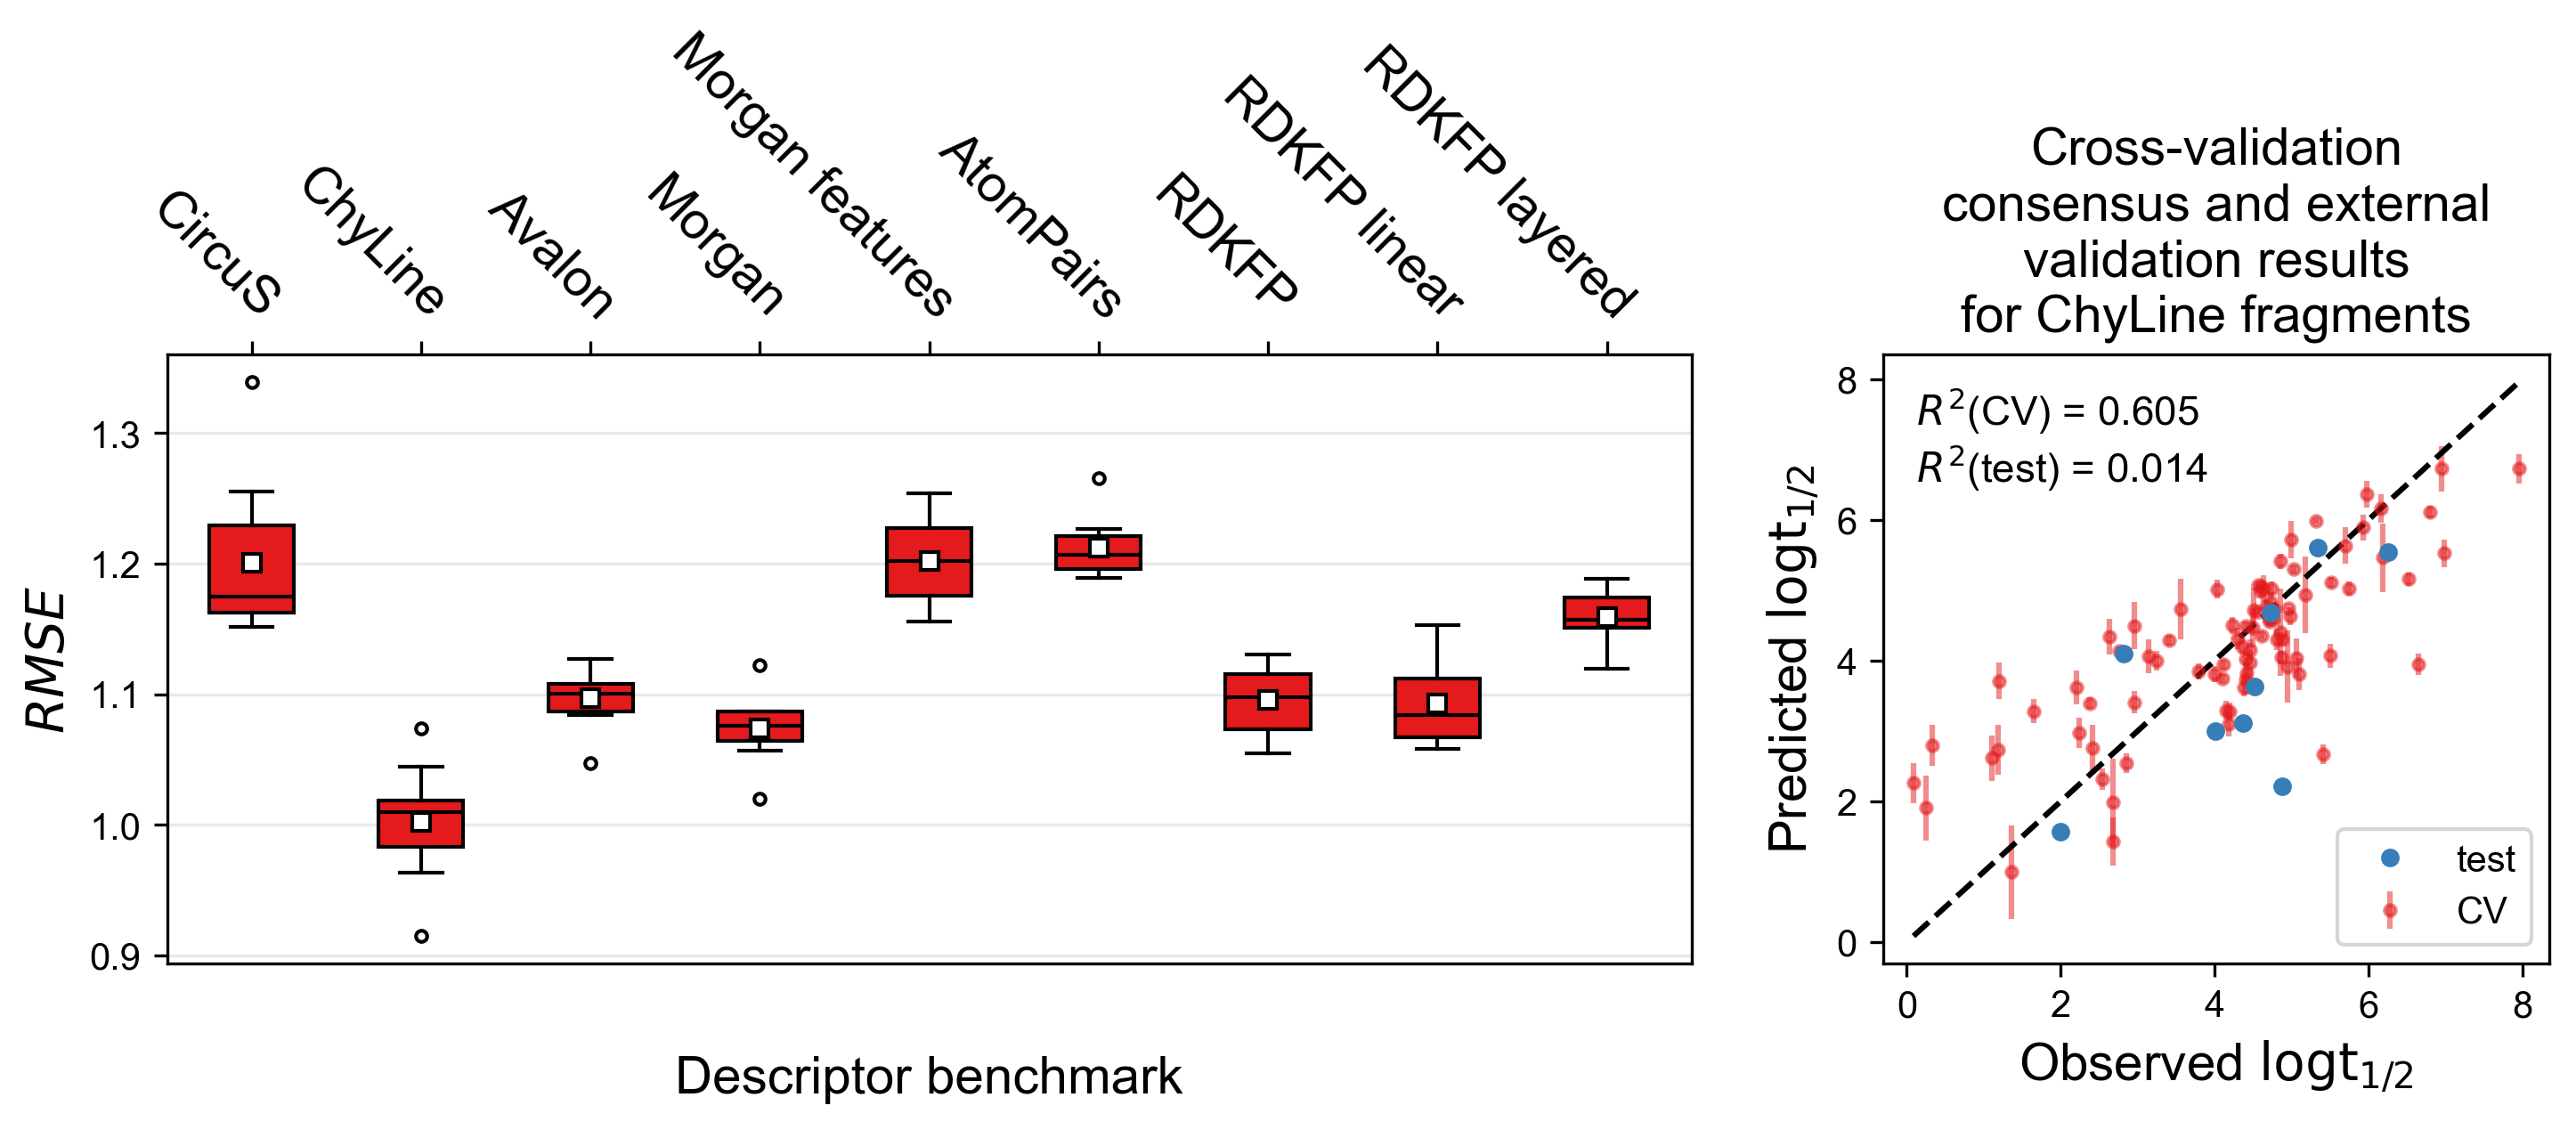

In [197]:
names = {'RDKFP':'models/logt12 Models/solvent_isolated_clean/Model_rdkfp',
         'RDKFP layered':'models/logt12 Models/solvent_isolated_clean/Model_layered',
         'ChyLine':'models/logt12 Models/solvent_isolated_clean/Model_chyline',
         'Morgan':'models/logt12 Models/solvent_isolated_clean/Model_morgan',
         'CircuS':'models/logt12 Models/solvent_isolated_clean/Model_circus',
         'RDKFP linear':'models/logt12 Models/solvent_isolated_clean/Model_rdkfplinear',
         'AtomPairs':'models/logt12 Models/solvent_isolated_clean/Model_atompairs',
         'Morgan features':'models/logt12 Models/solvent_isolated_clean/Model_morganfeatures',
         'Avalon':'models/logt12 Models/solvent_isolated_clean/Model_avalon'}

fig = plt.figure(figsize = (10,4.8), dpi=300, facecolor="w")

ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 3), (0, 2))

cv_r2_results = []
for i, dtype in enumerate(["CircuS", "ChyLine", "Avalon", "Morgan", 'Morgan features', 'AtomPairs', 
                           "RDKFP", "RDKFP linear", 'RDKFP layered']):
    d = dtype.lower()
    cv_r2_results.append([])

    best = pd.read_table(names[dtype]+'/trials.best', sep=' ').iloc[0].trial
    cv_res = pd.read_table(names[dtype]+"/trial."+str(best)+"/predictions", sep=' ')
    a = cv_res["logt12.observed"]
    for i in range(1,11):
        b = cv_res['logt12.predicted.repeat'+str(i)]
        cv_r2_results[-1].append(rmse(a,b))

bp1 = ax1.boxplot(cv_r2_results, positions=[0,1,2,3,4,5,6,7,8],
                  patch_artist=True, showmeans=True)
for median in bp1['medians']:
    median.set(color='k', linewidth=1)
for mean in bp1['means']:
    mean.set(marker='s', markerfacecolor='w', markeredgecolor='k', markersize=5)
for item in ['boxes', 'whiskers', 'fliers', 'caps']:
        plt.setp(bp1[item], color='k')
plt.setp(bp1["boxes"], facecolor=colors[0], edgecolor='k')
plt.setp(bp1["fliers"], markeredgecolor='k', markersize=3)

ax1.set_xticks([0,1,2,3,4,5,6,7,8])
ax1.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
ax1.set_xticklabels(["CircuS", "ChyLine", "Avalon", "Morgan", 'Morgan features', 'AtomPairs', 
                           "RDKFP", "RDKFP linear", 'RDKFP layered'], 
                    rotation=-45, fontsize=14,
                    ha="right",rotation_mode="anchor")
ax1.set_ylabel(r"$RMSE$", fontsize=14)#, rotation=0, labelpad=-15, loc="top")
#ax.set_ylim([0.75, 0.95])
ax1.grid(color="lightgrey", axis="y", alpha=.5)
ax1.text(0.5, -0.15, 'Descriptor benchmark', transform=ax1.transAxes,
                       fontsize=14, color='k',
                       verticalalignment="top", horizontalalignment="center")

best_regr = pd.read_table(names["ChyLine"]+'/trials.best', sep=' ').iloc[0]

from doptools.cli.rebuilder import rebuild_from_file

train_aceto = pd.read_table("models/logt12 Models/solvent_isolated_clean/train-aceto.csv", sep=",")
train_aceto["mol"] = [smiles(c) for c in train_aceto["SMILES"]]
test_aceto = pd.read_table("models/logt12 Models/solvent_isolated_clean/test-aceto.csv", sep=",")
test_aceto["mol"] = [smiles(c) for c in test_aceto["SMILES"]]
pipeline, trial = rebuild_from_file("models/logt12 Models/solvent_isolated_clean/desc/chyline", 
                                    names["ChyLine"], best_regr["trial"])
pipeline.fit(train_aceto["mol"], train_aceto["logt12"])
cv_res = pd.read_table(names['ChyLine']+"/trial."+str(best_regr["trial"])+"/predictions", sep=' ')
a = cv_res["logt12.observed"]
b = cv_res[['logt12.predicted.repeat'+str(i) for i in range(1,11)]]
    
ax2.errorbar(a,b.mean(axis=1), b.std(axis=1), fmt=".", color=colors[0], alpha=0.5, label="CV")
    
ax2.plot([a.min(), a.max()], [a.min(), a.max()], "k--")

ext_preds = pipeline.predict(test_aceto["mol"])
print(rmse(a,b.mean(axis=1)))

ax2.plot(test_aceto["logt12"], ext_preds, 'o', color=colors[1], markersize=4,  zorder=10, label="test")
ax2.set_xlabel(r"Observed $\rm{log} t_{1/2}$", fontsize=14)
ax2.set_ylabel(r"Predicted $\rm{log} t_{1/2}$", fontsize=14)
ax2.set_title('Cross-validation\nconsensus and external\nvalidation results\nfor ChyLine fragments', fontsize=14)
#textstr = r"$RMSE$(CV) = " + str(round(rmse(a,b.mean(axis=1)),2)) + '\n' + 
print(rmse(test_aceto["logt12"], ext_preds))
textstr = r"$R^2$(CV) = " + str(round(r2(a,b.mean(axis=1)), 3))
textstr += '\n' + r"$R^2$(test) = " + str(round(r2(test_aceto["logt12"], ext_preds), 3))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes,
                       fontsize=11, color='k',
                       verticalalignment="top", horizontalalignment="left",
                       bbox={"boxstyle":"round", "facecolor":"white", "alpha":0})

ax2.legend(loc=4)
plt.tight_layout(pad=2)
plt.savefig("Benchmark logt12 - acetonitrile test set.png", dpi=300)

### Full test set ColorAtom

### log$t_{1/2}$

In [162]:
ca = ColorAtom(colormap=RWB)

with open("Model files/SVR_Htime/SVR_trial57_chyline_2_6.pkl", "rb") as f:
    model = pickle.load(f)
model.fit(fdata_log.loc[train_logt12]["mol"], fdata_log.loc[train_logt12]["logt12"])

ca.set_pipeline(model)

contr = []
#indices = [12,13,1,8,4]
for i in range(len(test_logt12)):
    m = fdata_log["mol"].loc[test_logt12[i]]
    contr += [v for v in ca.calculate_atom_contributions(m)[m].values()]

max_value = np.max(np.abs(contr))

for i in range(len(test_logt12)):
    print(test_logt12[i], fdata_log["logt12"].loc[test_logt12[i]], model.predict([fdata_log["mol"].loc[test_logt12[i]]]))
    svgs = ca._draw_one_molecule(fdata_log["mol"].loc[test_logt12[i]], colorbar=True, external_limits=[-max_value, max_value])
    no_wrap_div = '<div style="white-space: nowrap; align-items: middle">'+'{}'*len(svgs)+'</div>'
    display(HTML(no_wrap_div.format(*svgs)))

/Users/pavel/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator VarianceThreshold from version 1.5.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/pavel/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVR from version 1.5.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/pavel/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.5.0 when us

246 6.0918497799439555 [5.99967634]


68 5.082641778157131 [5.2458667]


778 5.9141448946219555 [5.9437093]


788 4.405107201819091 [4.53778247]


645 1.0334237554869496 [2.96858439]


251 4.87842973482913 [4.3411106]


60 4.763128376799137 [5.06328712]


219 4.635483746814912 [1.62794383]


780 7.89784259993673 [5.8789567]


421 4.359076226059263 [3.84227517]


245 3.597695185925512 [5.80700123]


50 2.4075608494863627 [3.32153344]


420 4.10407720615511 [3.40690197]


636 0.25527250510330607 [1.91104748]


### $\lambda_{max}$

Here output is the HTML table, adjust accordingly.

In [171]:
ca = ColorAtom(colormap=RWB)

with open("Model files/SVR_lambda/SVR_trial126_Circus_0_2.pkl", "rb") as f:
    model_lambda = pickle.load(f)
model_lambda.fit(fdata_lambda.loc[train_lambda]["mol"], fdata_lambda.loc[train_lambda]["lambda"])

ca_lambda.set_pipeline(model_lambda)

contr_lambda = []
for i in range(len(test_lambda)):
    m = fdata_lambda["mol"].loc[test_lambda[i]]
    contr_lambda += [v for v in ca_lambda.calculate_atom_contributions(m)[m].values()]

max_value_lambda = np.max(np.abs(contr_lambda))

lambda_coloratom_output = pd.DataFrame(index=np.arange(0, len(test_lambda)), columns=["index", "exp", "pred", "ColorAtom individual", "ColorAtom scaled"])

for i in range(len(test_lambda)):
    #print(test_lambda[i], fdata_lambda["lambda"].loc[test_lambda[i]], model_lambda.predict([fdata_lambda["mol"].loc[test_lambda[i]]]))
    svgs_original = ca_lambda._draw_one_molecule(fdata_lambda["mol"].loc[test_lambda[i]], colorbar=True)
    svgs_scaled = ca_lambda._draw_one_molecule(fdata_lambda["mol"].loc[test_lambda[i]], colorbar=True, 
                                        external_limits=[-max_value_lambda, max_value_lambda])
    no_wrap_div = '<div style="white-space: nowrap; align-items: middle">{}{}</div>'
    lambda_coloratom_output.loc[i] = [test_lambda[i], fdata_lambda["lambda"].loc[test_lambda[i]], 
                                      model_lambda.predict([fdata_lambda["mol"].loc[test_lambda[i]]]),
                                      no_wrap_div.format(*svgs_original),
                                      no_wrap_div.format(*svgs_scaled)]
    #display(HTML(no_wrap_div.format(*svgs)))

#with open('preds_lambda_test_set.html', 'w') as fo:
#    fo.write(lambda_coloratom_output.to_html(escape=False))

/Users/pavel/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator VarianceThreshold from version 1.5.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/pavel/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVR from version 1.5.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/pavel/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.5.0 when us

<div style="white-space: nowrap; align-items: middle"><svg style="background-color:white"  width="8.90cm" height="5.54cm" viewBox="-0.93 -4.91 8.90 5.54" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" version="1.1">
  <g id="2cf8f2a9-2c92-444f-b27f-8f1b5661750e-molecule">
    <defs>
      <g id="2cf8f2a9-2c92-444f-b27f-8f1b5661750e-symbols" font-size="0.50" font-family="sans-serif">
        <text id="2cf8f2a9-2c92-444f-b27f-8f1b5661750e-1" x="0.00" y="-0.00" dx="-0.20" dy="0.20">F</text>
        <text id="2cf8f2a9-2c92-444f-b27f-8f1b5661750e-3" x="1.13" y="-0.30" dx="-0.20" dy="0.20">F</text>
        <text id="2cf8f2a9-2c92-444f-b27f-8f1b5661750e-4" x="-0.30" y="-1.13" dx="-0.20" dy="0.20">F</text>
        <text id="2cf8f2a9-2c92-444f-b27f-8f1b5661750e-11" x="-0.00" y="-4.29" dx="-0.20" dy="0.20">F</text>
        <text id="2cf8f2a9-2c92-444f-b27f-8f1b5661750e-12" x="-0.30" y="-3.16" dx="-0.20" dy="0.20">F</text>
        <text id="2cf8f2a9-2c92-444f-b27f-8

## Predicting transition energy

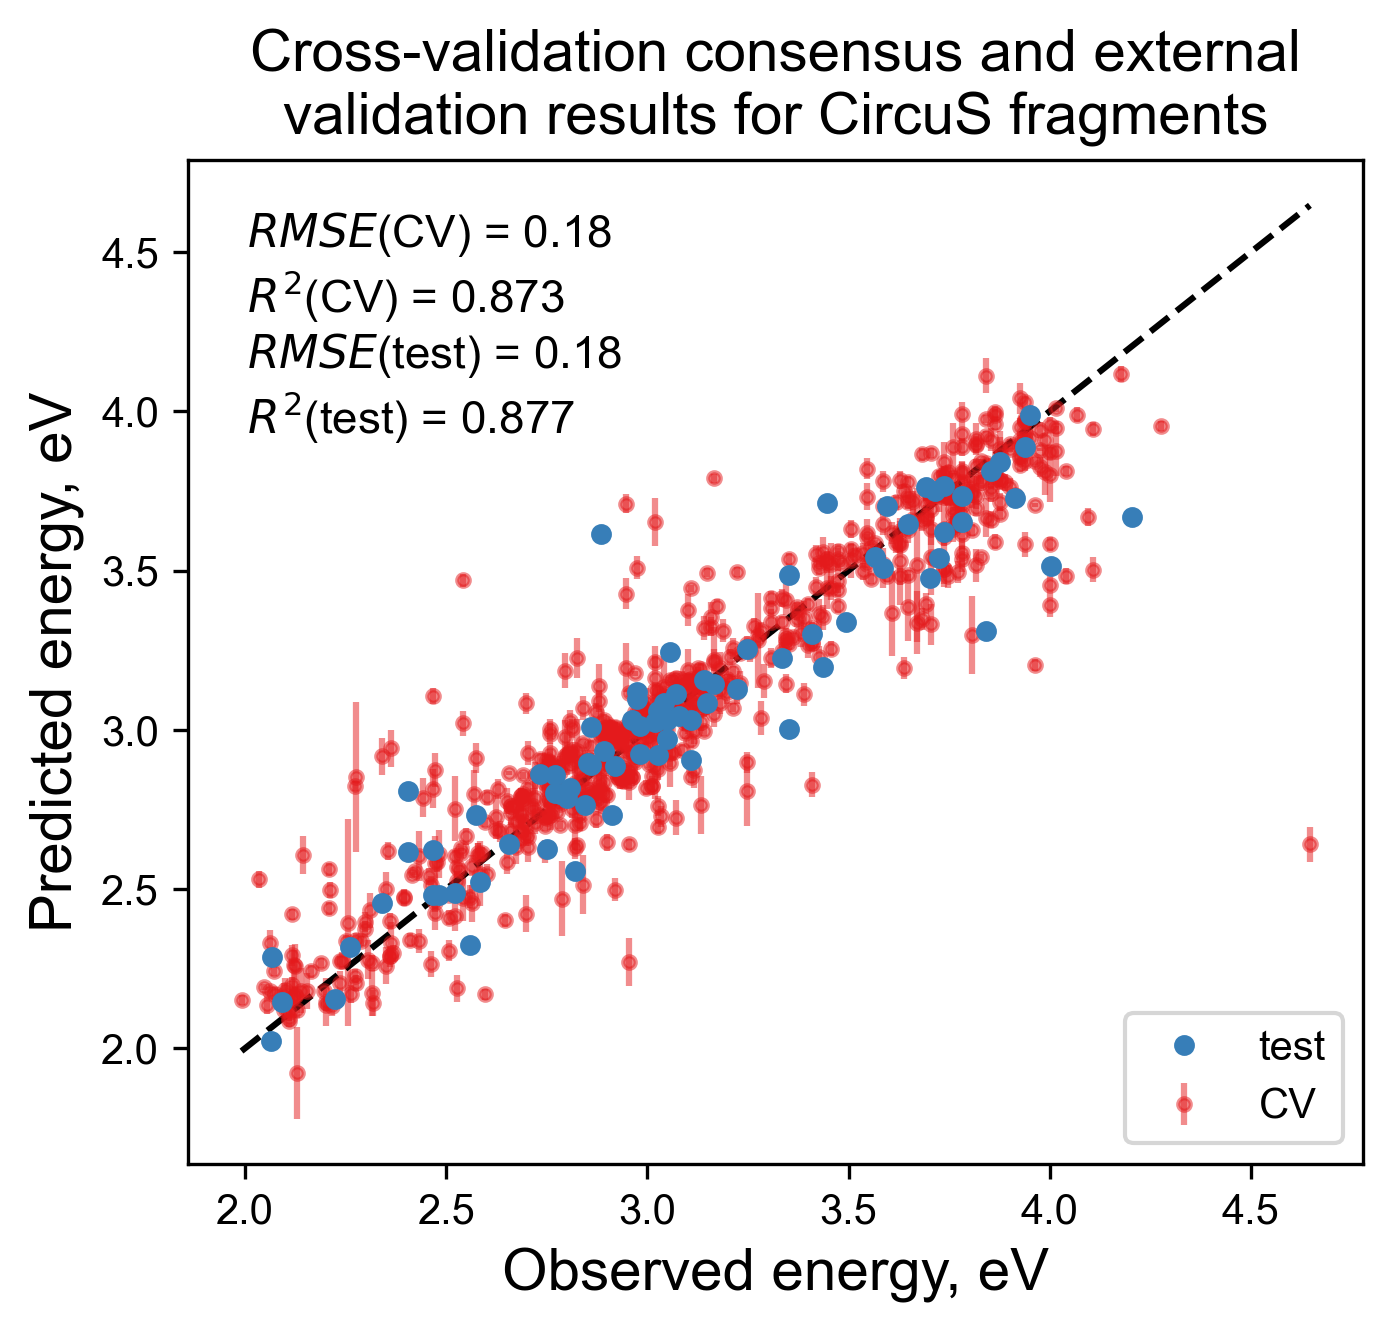

In [38]:
from doptools.cli.rebuilder import rebuild_from_file

fig, ax = plt.subplots(figsize = (5,4.8), dpi=300, facecolor="w")

best = pd.read_table('azo/Model_ev/trials.best', sep=' ').iloc[0].trial
cv_res = pd.read_table("azo/Model_ev/trial."+str(best)+"/predictions", sep=' ')
a = cv_res["ev.observed"]
b = cv_res[['ev.predicted.repeat'+str(i) for i in range(1,11)]]

ax.errorbar(a,b.mean(axis=1), b.std(axis=1), fmt=".", color=colors[0], alpha=0.5, label="CV")
    
ax.plot([a.min(), a.max()], [a.min(), a.max()], "k--")

pipeline_ev, trial = rebuild_from_file("azo/ev", "azo/Model_ev", best)
pipeline_ev.fit(fdata_lambda.loc[train_lambda]["mol"], fdata_lambda.loc[train_lambda]["E (eV)"])
ext_preds = pipeline_ev.predict(fdata_lambda.loc[test_lambda]["mol"])

ax.plot(fdata_lambda.loc[test_lambda]["E (eV)"], ext_preds, 'o', color=colors[1], markersize=4,  zorder=10, label="test")
ax.set_xlabel(r"Observed energy, eV", fontsize=14)
ax.set_ylabel(r"Predicted energy, eV", fontsize=14)
ax.set_title('Cross-validation consensus and external\nvalidation results for CircuS fragments', fontsize=14)
textstr = r"$RMSE$(CV) = " + str(round(rmse(a,b.mean(axis=1)),2)) + '\n'
textstr += r"$R^2$(CV) = " + str(round(r2(a,b.mean(axis=1)), 3))
textstr += '\n' + r"$RMSE$(test) = " + str(round(rmse(fdata_lambda.loc[test_lambda]["E (eV)"], ext_preds), 2))
textstr += '\n' + r"$R^2$(test) = " + str(round(r2(fdata_lambda.loc[test_lambda]["E (eV)"], ext_preds), 3))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes,
                       fontsize=11, color='k',
                       verticalalignment="top", horizontalalignment="left",
                       bbox={"boxstyle":"round", "facecolor":"white", "alpha":0})
#
ax.legend(loc=4)
plt.tight_layout(pad=2)
plt.savefig("ev predictions.png")

## Models for absorption maximum with solvents

(506, 10) (60, 10)


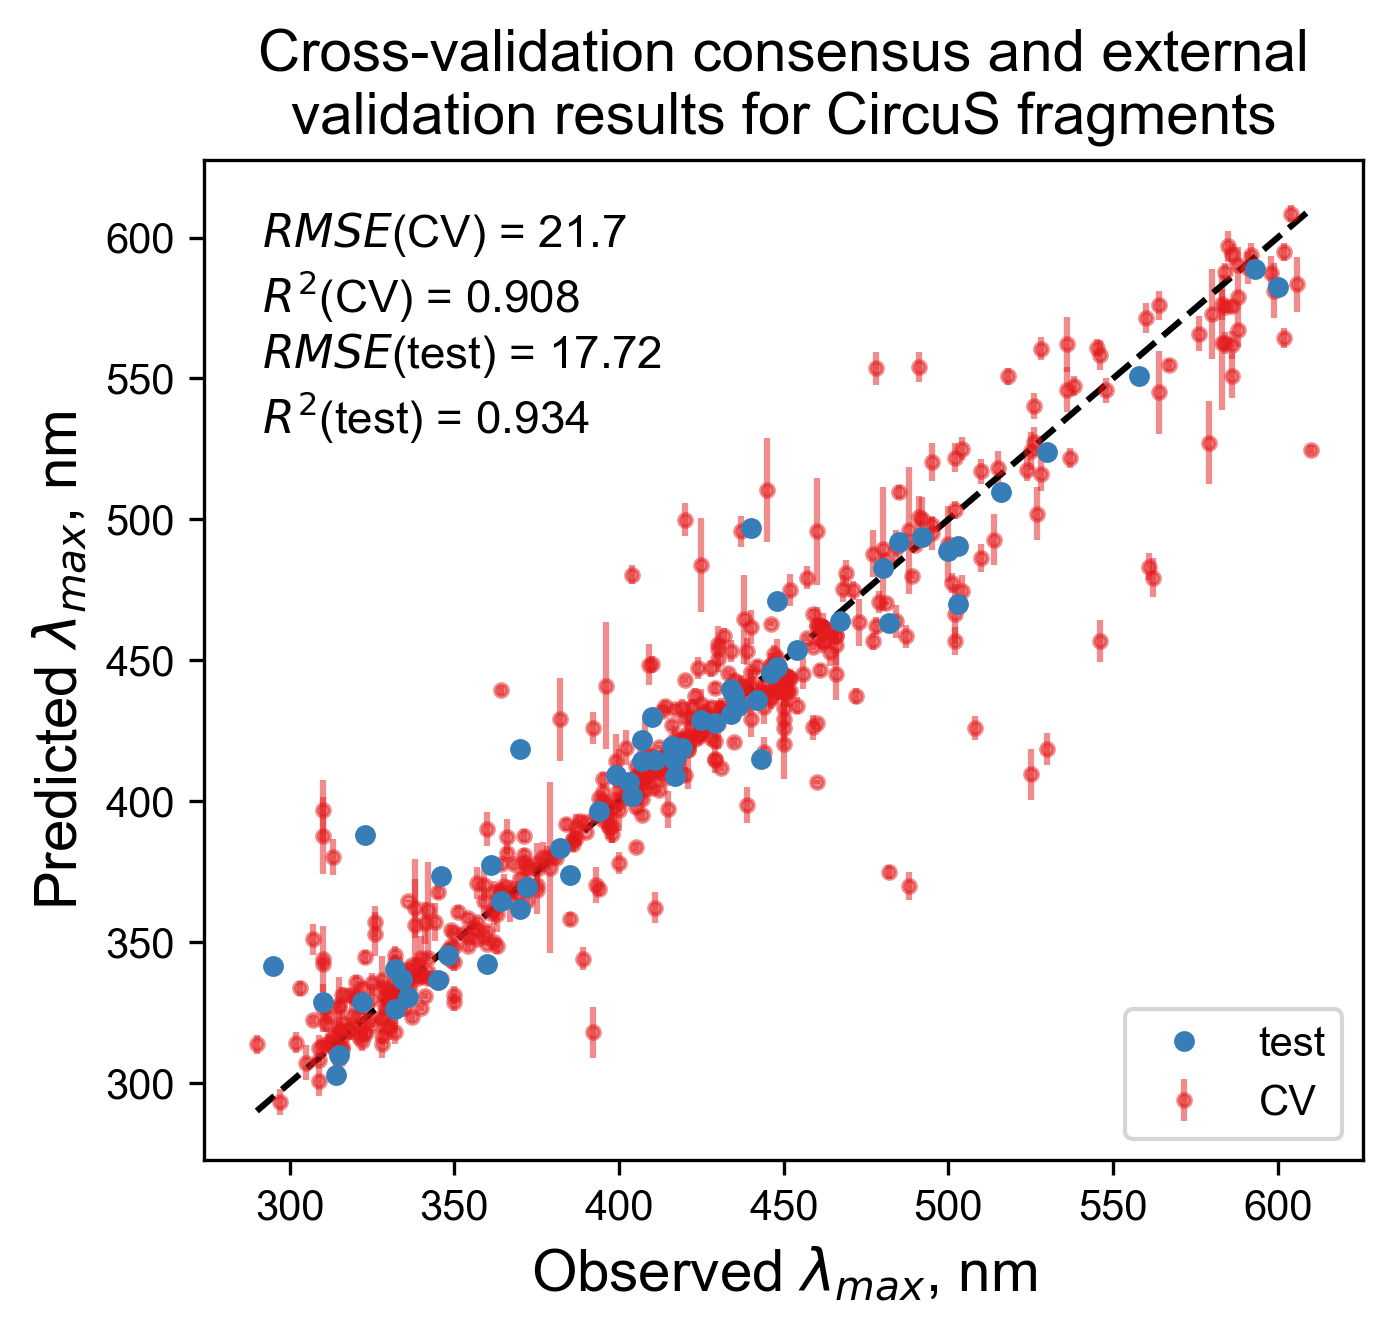

In [39]:
from doptools.cli.rebuilder import rebuild_from_file

fig, ax = plt.subplots(figsize = (5,4.8), dpi=300, facecolor="w")

best = pd.read_table('azo/Model_lambda_solv/trials.best', sep=' ').iloc[0].trial
cv_res = pd.read_table("azo/Model_lambda_solv/trial."+str(best)+"/predictions", sep=' ')
a = cv_res["lambda.observed"]
b = cv_res[['lambda.predicted.repeat'+str(i) for i in range(1,11)]]

ax.errorbar(a,b.mean(axis=1), b.std(axis=1), fmt=".", color=colors[0], alpha=0.5, label="CV")
    
ax.plot([a.min(), a.max()], [a.min(), a.max()], "k--")

l_solv_train = pd.read_excel("fulldata.lambda_solvent_train.xlsx")
l_solv_test = pd.read_excel("fulldata.lambda_solvent_test.xlsx")

print(l_solv_train.shape, l_solv_test.shape)

pipeline_solv, trial = rebuild_from_file("azo/lambda_solv", "azo/Model_lambda_solv", best)
pipeline_solv[0].associator[0][1].fmt ="smiles"
pipeline_solv.fit(l_solv_train, l_solv_train["lambda"])
ext_preds = pipeline_solv.predict(l_solv_test)

ax.plot(l_solv_test["lambda"], ext_preds, 'o', color=colors[1], markersize=4,  zorder=10, label="test")
ax.set_xlabel(r"Observed $\lambda_{max}$, nm", fontsize=14)
ax.set_ylabel(r"Predicted $\lambda_{max}$, nm", fontsize=14)
ax.set_title('Cross-validation consensus and external\nvalidation results for CircuS fragments', fontsize=14)
textstr = r"$RMSE$(CV) = " + str(round(rmse(a,b.mean(axis=1)),2)) + '\n'
textstr += r"$R^2$(CV) = " + str(round(r2(a,b.mean(axis=1)), 3))
textstr += '\n' + r"$RMSE$(test) = " + str(round(rmse(l_solv_test["lambda"], ext_preds), 2))
textstr += '\n' + r"$R^2$(test) = " + str(round(r2(l_solv_test["lambda"], ext_preds), 3))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes,
                       fontsize=11, color='k',
                       verticalalignment="top", horizontalalignment="left",
                       bbox={"boxstyle":"round", "facecolor":"white", "alpha":0})
#
ax.legend(loc=4)
plt.tight_layout(pad=2)
plt.savefig("lambda solvent predictions.png")

In [40]:
pipeline_solv

Pipeline(steps=[('descriptor_calculator',
                 ComplexFragmentor(associator=[('SMILES',
                                                ChythonCircus(fmt='smiles',
                                                              upper=2)),
                                               ('solvent',
                                                SolventVectorizer())],
                                   structure_columns=['SMILES'])),
                ('variance', VarianceThreshold()),
                ('model',
                 SVR(C=2623.8237173278667, coef0=-3.4531027090853583,
                     gamma='auto'))])

In [42]:
pd.read_table('azo/Model_lambda_solv/trials.best', sep=' ').iloc[0]

trial              477
score         0.908311
desc        circus_0_2
scaling       original
method             SVR
C          2623.823717
kernel             rbf
coef0        -3.453103
Name: 0, dtype: object